# Probing GAT

Here we'll first be loading the FC matrices and explore their structure

In [1]:
import torch_geometric
print(torch_geometric.__version__)

2.5.3


In [2]:
#using read_dataset from Datasets/FC/create_dataset.py to read the dataset
from Datasets.FC.create_dataset import read_dataset

In [3]:
dataset = read_dataset()

In [4]:
#ok, let's explore the data a bit more
#dataset is a list object of torch_geometric.data objects

#let's see the first element
print(dataset[0])

#it's a dictionary object, let's see the keys
print(dataset[0].keys())

#ok, let's see the values
print(dataset[0].values())

#it has 4 keys, 'x', 'edge_index', 'edge_attr' and 'y' where y=0 menas the patient is healthy and y=1 means the patient has Autism Spectrum Disorder (ASD)
"""graph = Data(x=ROI.reshape(-1,116).float(),
                     edge_index=G.indices().reshape(2,-1).long(),
                     edge_attr=G.values().reshape(-1,1).float(),
                     y=y.long())"""

#how much data do we have?
len(dataset)


Data(x=[116, 116], edge_index=[2, 1016], edge_attr=[1016, 1], y=[1])
['y', 'edge_index', 'edge_attr', 'x']
ValuesView({'x': tensor([[ 0.0000,  0.4543,  0.2477,  ...,  0.1753,  0.2247, -0.1751],
        [ 0.4543,  0.0000, -0.2204,  ..., -0.1947, -0.2258, -0.1434],
        [ 0.2477, -0.2204,  0.0000,  ..., -0.0521, -0.0804, -0.2025],
        ...,
        [ 0.1753, -0.1947, -0.0521,  ...,  0.0000,  0.6875, -0.1364],
        [ 0.2247, -0.2258, -0.0804,  ...,  0.6875,  0.0000,  0.0929],
        [-0.1751, -0.1434, -0.2025,  ..., -0.1364,  0.0929,  0.0000]]), 'edge_index': tensor([[  0,   0,   0,  ..., 114, 115, 115],
        [  1,  10,  12,  ..., 113,  94, 109]]), 'edge_attr': tensor([[0.4543],
        [0.5913],
        [0.4224],
        ...,
        [0.6875],
        [0.4846],
        [0.5437]]), 'y': tensor([0])})


1099

In [5]:
#set the seed
import torch
torch.manual_seed(0)

MODEL = "GAT"
DATASET = "FC"

from models.models_FC import GAT_framework as framework # import the model

gnn = framework(dataset)

print(gnn.model)
print(gnn.train_idx)

Net(
  (conv_layers): ModuleList(
    (0): GATConv(116, 128, heads=4)
    (1-4): 4 x GATConv(512, 128, heads=4)
  )
  (batch_norms): ModuleList(
    (0-4): 5 x BatchNorm(512)
  )
  (lin1): Linear(512, 128, bias=True)
  (lin2): Linear(128, 2, bias=True)
  (bn1): BatchNorm(128)
  (bn2): BatchNorm(2)
)
tensor([217, 137, 426,  ..., 643, 205, 434])


c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
# gnn.iterate()

In [7]:
#gnn.train()

In [8]:
#save the model 
# gnn.save_model(path="models/"+DATASET+"_"+MODEL+"server2.pt")

In [9]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server2.pt", map_location='cpu')

In [10]:
gnn.evaluate()

Test Loss: 0.898, Train Acc: 1.000 Test Acc: 0.618


### Properties

In [13]:
import pickle as pkl
import networkx as nx

def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the average path length of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    
def calculate_small_world(G):
    if nx.is_connected(G):
        return nx.algorithms.smallworld.sigma(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the small world coefficient of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.algorithms.smallworld.sigma(largest_component)
    
def compute_swi(graph):
    # Calculate clustering coefficient and average path length for the given graph
    clustering_coeff = nx.average_clustering(graph)
    avg_path_len = calculate_avg_path_length(graph)
    
    # Generate a random graph with the same number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    random_graph = nx.gnm_random_graph(num_nodes, num_edges)
    
    # Generate a lattice graph with the same number of nodes and edges
    lattice_graph = nx.watts_strogatz_graph(num_nodes, k=4, p=0)  # Adjust k as needed
    
    # Calculate clustering coefficient and average path length for the random graph
    random_clustering_coeff = nx.average_clustering(random_graph)
    random_avg_path_len = calculate_avg_path_length(random_graph)
    
    # Calculate clustering coefficient and average path length for the lattice graph
    lattice_clustering_coeff = nx.average_clustering(lattice_graph)
    lattice_avg_path_len = calculate_avg_path_length(lattice_graph)
    
    # Compute the Small-World Index (SWI)
    swi = ((avg_path_len - lattice_avg_path_len) / (random_avg_path_len - lattice_avg_path_len)) * \
          ((clustering_coeff - random_clustering_coeff) / (lattice_clustering_coeff - random_clustering_coeff))
    
    return swi
    

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = calculate_avg_path_length(G)
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_node_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        assortativity = nx.degree_assortativity_coefficient(G)
        small_world = compute_swi(G)
            
        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_node_in_the_largest_fully_connected_component, assortativity, small_world))
    return properties

train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties = compute_graph_properties(selected_dataset)

# Save the properties to files
with open("results/"+DATASET+"_"+MODEL+"_train_properties_with_sm.pkl", "wb") as f:
    pkl.dump(train_properties, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_with_sm.pkl", "wb") as f:
    pkl.dump(test_properties, f)

In [11]:
import pickle as pkl
# save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_with_sm.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_with_sm.pkl", "rb") as f:
    test_properties = pkl.load(f)

### Features

In [12]:
train_features, test_features = gnn.evaluate_with_features2()

In [17]:
print(len(train_features[0]))
len(train_features), len(test_features)

8


(1044, 55)

In [13]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component','assortativity', 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

### Diagnostic classifier

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score


#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    # Flatten the embeddings before determining the input size
    train_embedding_flat = train_embedding.view(train_embedding.size(0), -1)
    test_embedding_flat = test_embedding.view(test_embedding.size(0), -1)
    #print the shapes
    print(train_embedding_flat.shape)
    print(test_embedding_flat.shape)
    input_size = train_embedding_flat.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 2000000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding_flat).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding_flat).squeeze().cpu().numpy()
            test_pred = model(test_embedding_flat).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_full_embedding.pkl", "wb") as f:
    pkl.dump(results, f)

torch.Size([1044, 59392])
torch.Size([55, 59392])
Epoch [1000/2000000], Property: num_nodes, Loss: 0.0001
Epoch [2000/2000000], Property: num_nodes, Loss: 0.0000
Epoch [3000/2000000], Property: num_nodes, Loss: 0.0000
Epoch [4000/2000000], Property: num_nodes, Loss: 0.0000
Early stopping at epoch 4648
Embedding: torch.Size([1044, 116, 512])
Property: num_nodes
  Train MSE: 0.0000, Test MSE: 15.3042
  Train R²: 1.0000, Test R²: -16.3781
Epoch [1000/2000000], Property: num_edges, Loss: 95.5787
Epoch [2000/2000000], Property: num_edges, Loss: 3.1012
Epoch [3000/2000000], Property: num_edges, Loss: 0.0338
Epoch [4000/2000000], Property: num_edges, Loss: 0.0008
Epoch [5000/2000000], Property: num_edges, Loss: 0.0000
Epoch [6000/2000000], Property: num_edges, Loss: 0.0000
Epoch [7000/2000000], Property: num_edges, Loss: 0.0000
Epoch [8000/2000000], Property: num_edges, Loss: 0.0000
Early stopping at epoch 8576
Embedding: torch.Size([1044, 116, 512])
Property: num_edges
  Train MSE: 0.0000, T

Epoch [4000/2000000], Property: num_squares, Loss: 0.0011
Early stopping at epoch 4001
Embedding: torch.Size([1044, 116, 512])
Property: num_squares
  Train MSE: 0.0009, Test MSE: 0.4648
  Train R²: 0.9995, Test R²: 0.6852
Epoch [1000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 0.0000
Epoch [2000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 0.0000
Epoch [3000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 0.0000
Epoch [4000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 0.0000
Early stopping at epoch 4254
Embedding: torch.Size([1044, 116, 512])
Property: number_of_nodes_in_the_largest_fully_connected_component
  Train MSE: 0.0000, Test MSE: 25.2958
  Train R²: 1.0000, Test R²: -7.3959
Epoch [1000/2000000], Property: assortativity, Loss: 0.0000
Epoch [2000/2000000], Property: assortativity, Loss: 0.0000
Epoch [3000/2000000], Property: a

Epoch [1000/2000000], Property: num_cliques, Loss: 0.0430
Epoch [2000/2000000], Property: num_cliques, Loss: 0.0000
Epoch [3000/2000000], Property: num_cliques, Loss: 0.0000
Epoch [4000/2000000], Property: num_cliques, Loss: 0.0000
Epoch [5000/2000000], Property: num_cliques, Loss: 0.0000
Early stopping at epoch 5646
Embedding: torch.Size([1044, 116, 512])
Property: num_cliques
  Train MSE: 0.0000, Test MSE: 383.1815
  Train R²: 1.0000, Test R²: 0.5006
Epoch [1000/2000000], Property: num_triangles, Loss: 34566.4570
Epoch [2000/2000000], Property: num_triangles, Loss: 6208.5029
Epoch [3000/2000000], Property: num_triangles, Loss: 821.4818
Epoch [4000/2000000], Property: num_triangles, Loss: 56.2558
Epoch [5000/2000000], Property: num_triangles, Loss: 1.3949
Epoch [6000/2000000], Property: num_triangles, Loss: 0.0088
Epoch [7000/2000000], Property: num_triangles, Loss: 0.0000
Epoch [8000/2000000], Property: num_triangles, Loss: 0.0000
Epoch [9000/2000000], Property: num_triangles, Loss: 

Epoch [3000/2000000], Property: num_nodes, Loss: 227.1895
Epoch [4000/2000000], Property: num_nodes, Loss: 171.8927
Epoch [5000/2000000], Property: num_nodes, Loss: 136.3584
Epoch [6000/2000000], Property: num_nodes, Loss: 111.9296
Epoch [7000/2000000], Property: num_nodes, Loss: 93.7536
Epoch [8000/2000000], Property: num_nodes, Loss: 80.3939
Epoch [9000/2000000], Property: num_nodes, Loss: 70.7305
Epoch [10000/2000000], Property: num_nodes, Loss: 63.7414
Epoch [11000/2000000], Property: num_nodes, Loss: 58.8306
Epoch [12000/2000000], Property: num_nodes, Loss: 55.5613
Epoch [13000/2000000], Property: num_nodes, Loss: 53.4721
Epoch [14000/2000000], Property: num_nodes, Loss: 52.1247
Epoch [15000/2000000], Property: num_nodes, Loss: 51.1336
Epoch [16000/2000000], Property: num_nodes, Loss: 50.2283
Epoch [17000/2000000], Property: num_nodes, Loss: 49.3351
Epoch [18000/2000000], Property: num_nodes, Loss: 48.4473
Epoch [19000/2000000], Property: num_nodes, Loss: 47.5662
Epoch [20000/2000

Epoch [145000/2000000], Property: num_nodes, Loss: 0.5041
Epoch [146000/2000000], Property: num_nodes, Loss: 0.5040
Epoch [147000/2000000], Property: num_nodes, Loss: 0.5040
Epoch [148000/2000000], Property: num_nodes, Loss: 0.5039
Epoch [149000/2000000], Property: num_nodes, Loss: 0.5039
Epoch [150000/2000000], Property: num_nodes, Loss: 0.5043
Epoch [151000/2000000], Property: num_nodes, Loss: 0.5102
Epoch [152000/2000000], Property: num_nodes, Loss: 0.5039
Epoch [153000/2000000], Property: num_nodes, Loss: 0.5039
Epoch [154000/2000000], Property: num_nodes, Loss: 0.5039
Epoch [155000/2000000], Property: num_nodes, Loss: 0.5039
Epoch [156000/2000000], Property: num_nodes, Loss: 0.5039
Epoch [157000/2000000], Property: num_nodes, Loss: 0.5039
Epoch [158000/2000000], Property: num_nodes, Loss: 0.5039
Epoch [159000/2000000], Property: num_nodes, Loss: 0.5039
Epoch [160000/2000000], Property: num_nodes, Loss: 0.5039
Epoch [161000/2000000], Property: num_nodes, Loss: 0.5039
Epoch [162000/

Epoch [116000/2000000], Property: num_edges, Loss: 3671.4563
Epoch [117000/2000000], Property: num_edges, Loss: 3664.9658
Epoch [118000/2000000], Property: num_edges, Loss: 3658.4834
Epoch [119000/2000000], Property: num_edges, Loss: 3652.0095
Epoch [120000/2000000], Property: num_edges, Loss: 3645.5444
Epoch [121000/2000000], Property: num_edges, Loss: 3639.0867
Epoch [122000/2000000], Property: num_edges, Loss: 3632.6379
Epoch [123000/2000000], Property: num_edges, Loss: 3626.1970
Epoch [124000/2000000], Property: num_edges, Loss: 3619.7651
Epoch [125000/2000000], Property: num_edges, Loss: 3613.3413
Epoch [126000/2000000], Property: num_edges, Loss: 3606.9260
Epoch [127000/2000000], Property: num_edges, Loss: 3600.5186
Epoch [128000/2000000], Property: num_edges, Loss: 3594.1201
Epoch [129000/2000000], Property: num_edges, Loss: 3587.7300
Epoch [130000/2000000], Property: num_edges, Loss: 3581.3477
Epoch [131000/2000000], Property: num_edges, Loss: 3574.9741
Epoch [132000/2000000], 

Epoch [251000/2000000], Property: num_edges, Loss: 2875.4126
Epoch [252000/2000000], Property: num_edges, Loss: 2870.0833
Epoch [253000/2000000], Property: num_edges, Loss: 2864.7620
Epoch [254000/2000000], Property: num_edges, Loss: 2859.4490
Epoch [255000/2000000], Property: num_edges, Loss: 2854.1438
Epoch [256000/2000000], Property: num_edges, Loss: 2848.8491
Epoch [257000/2000000], Property: num_edges, Loss: 2843.5640
Epoch [258000/2000000], Property: num_edges, Loss: 2838.2886
Epoch [259000/2000000], Property: num_edges, Loss: 2833.0068
Epoch [260000/2000000], Property: num_edges, Loss: 2827.7483
Epoch [261000/2000000], Property: num_edges, Loss: 2822.4878
Epoch [262000/2000000], Property: num_edges, Loss: 2817.2456
Epoch [263000/2000000], Property: num_edges, Loss: 2811.9395
Epoch [264000/2000000], Property: num_edges, Loss: 2806.6301
Epoch [265000/2000000], Property: num_edges, Loss: 2801.3313
Epoch [266000/2000000], Property: num_edges, Loss: 2796.0396
Epoch [267000/2000000], 

Epoch [386000/2000000], Property: num_edges, Loss: 2222.7183
Epoch [387000/2000000], Property: num_edges, Loss: 2218.4546
Epoch [388000/2000000], Property: num_edges, Loss: 2214.1995
Epoch [389000/2000000], Property: num_edges, Loss: 2209.9526
Epoch [390000/2000000], Property: num_edges, Loss: 2205.7144
Epoch [391000/2000000], Property: num_edges, Loss: 2201.4846
Epoch [392000/2000000], Property: num_edges, Loss: 2197.2634
Epoch [393000/2000000], Property: num_edges, Loss: 2193.0508
Epoch [394000/2000000], Property: num_edges, Loss: 2188.8462
Epoch [395000/2000000], Property: num_edges, Loss: 2184.6506
Epoch [396000/2000000], Property: num_edges, Loss: 2180.4639
Epoch [397000/2000000], Property: num_edges, Loss: 2176.2844
Epoch [398000/2000000], Property: num_edges, Loss: 2172.1145
Epoch [399000/2000000], Property: num_edges, Loss: 2167.9526
Epoch [400000/2000000], Property: num_edges, Loss: 2163.7996
Epoch [401000/2000000], Property: num_edges, Loss: 2159.6545
Epoch [402000/2000000], 

Epoch [521000/2000000], Property: num_edges, Loss: 1724.3932
Epoch [522000/2000000], Property: num_edges, Loss: 1721.3693
Epoch [523000/2000000], Property: num_edges, Loss: 1718.3539
Epoch [524000/2000000], Property: num_edges, Loss: 1715.3470
Epoch [525000/2000000], Property: num_edges, Loss: 1712.3467
Epoch [526000/2000000], Property: num_edges, Loss: 1709.3547
Epoch [527000/2000000], Property: num_edges, Loss: 1706.3711
Epoch [528000/2000000], Property: num_edges, Loss: 1703.3960
Epoch [529000/2000000], Property: num_edges, Loss: 1700.4277
Epoch [530000/2000000], Property: num_edges, Loss: 1697.4681
Epoch [531000/2000000], Property: num_edges, Loss: 1694.5157
Epoch [532000/2000000], Property: num_edges, Loss: 1691.5725
Epoch [533000/2000000], Property: num_edges, Loss: 1688.6362
Epoch [534000/2000000], Property: num_edges, Loss: 1685.7201
Epoch [535000/2000000], Property: num_edges, Loss: 1682.7894
Epoch [536000/2000000], Property: num_edges, Loss: 1679.8792
Epoch [537000/2000000], 

Epoch [656000/2000000], Property: num_edges, Loss: 1388.4515
Epoch [657000/2000000], Property: num_edges, Loss: 1386.5056
Epoch [658000/2000000], Property: num_edges, Loss: 1384.5686
Epoch [659000/2000000], Property: num_edges, Loss: 1382.6394
Epoch [660000/2000000], Property: num_edges, Loss: 1380.7180
Epoch [661000/2000000], Property: num_edges, Loss: 1378.8049
Epoch [662000/2000000], Property: num_edges, Loss: 1376.8994
Epoch [663000/2000000], Property: num_edges, Loss: 1375.0022
Epoch [664000/2000000], Property: num_edges, Loss: 1373.1132
Epoch [665000/2000000], Property: num_edges, Loss: 1371.2314
Epoch [666000/2000000], Property: num_edges, Loss: 1369.3582
Epoch [667000/2000000], Property: num_edges, Loss: 1367.4927
Epoch [668000/2000000], Property: num_edges, Loss: 1365.6353
Epoch [669000/2000000], Property: num_edges, Loss: 1363.7860
Epoch [670000/2000000], Property: num_edges, Loss: 1361.9445
Epoch [671000/2000000], Property: num_edges, Loss: 1360.1111
Epoch [672000/2000000], 

Epoch [791000/2000000], Property: num_edges, Loss: 1198.0942
Epoch [792000/2000000], Property: num_edges, Loss: 1197.2274
Epoch [793000/2000000], Property: num_edges, Loss: 1196.3685
Epoch [794000/2000000], Property: num_edges, Loss: 1195.5176
Epoch [795000/2000000], Property: num_edges, Loss: 1194.6748
Epoch [796000/2000000], Property: num_edges, Loss: 1193.8398
Epoch [797000/2000000], Property: num_edges, Loss: 1193.0128
Epoch [798000/2000000], Property: num_edges, Loss: 1192.1940
Epoch [799000/2000000], Property: num_edges, Loss: 1191.3828
Epoch [800000/2000000], Property: num_edges, Loss: 1190.5801
Epoch [801000/2000000], Property: num_edges, Loss: 1189.7852
Epoch [802000/2000000], Property: num_edges, Loss: 1188.9979
Epoch [803000/2000000], Property: num_edges, Loss: 1188.2190
Epoch [804000/2000000], Property: num_edges, Loss: 1187.4480
Epoch [805000/2000000], Property: num_edges, Loss: 1186.6852
Epoch [806000/2000000], Property: num_edges, Loss: 1185.9305
Epoch [807000/2000000], 

Epoch [3000/2000000], Property: density, Loss: 0.0001
Epoch [4000/2000000], Property: density, Loss: 0.0000
Epoch [5000/2000000], Property: density, Loss: 0.0000
Epoch [6000/2000000], Property: density, Loss: 0.0000
Epoch [7000/2000000], Property: density, Loss: 0.0000
Epoch [8000/2000000], Property: density, Loss: 0.0000
Epoch [9000/2000000], Property: density, Loss: 0.0000
Epoch [10000/2000000], Property: density, Loss: 0.0001
Epoch [11000/2000000], Property: density, Loss: 0.0000
Epoch [12000/2000000], Property: density, Loss: 0.0000
Epoch [13000/2000000], Property: density, Loss: 0.0000
Epoch [14000/2000000], Property: density, Loss: 0.0000
Epoch [15000/2000000], Property: density, Loss: 0.0000
Early stopping at epoch 15070
Embedding: torch.Size([1044, 1, 512])
Property: density
  Train MSE: 0.0198, Test MSE: 0.0172
  Train R²: -42.1553, Test R²: -42.0412
Epoch [1000/2000000], Property: avg_path_len, Loss: 0.0986
Epoch [2000/2000000], Property: avg_path_len, Loss: 0.0599
Epoch [300

Epoch [88000/2000000], Property: num_cliques, Loss: 355.2414
Epoch [89000/2000000], Property: num_cliques, Loss: 353.4304
Epoch [90000/2000000], Property: num_cliques, Loss: 351.6265
Epoch [91000/2000000], Property: num_cliques, Loss: 349.8317
Epoch [92000/2000000], Property: num_cliques, Loss: 348.0450
Epoch [93000/2000000], Property: num_cliques, Loss: 346.2665
Epoch [94000/2000000], Property: num_cliques, Loss: 344.4962
Epoch [95000/2000000], Property: num_cliques, Loss: 342.7344
Epoch [96000/2000000], Property: num_cliques, Loss: 340.9808
Epoch [97000/2000000], Property: num_cliques, Loss: 339.2379
Epoch [98000/2000000], Property: num_cliques, Loss: 337.4984
Epoch [99000/2000000], Property: num_cliques, Loss: 335.7697
Epoch [100000/2000000], Property: num_cliques, Loss: 334.0493
Epoch [101000/2000000], Property: num_cliques, Loss: 332.3368
Epoch [102000/2000000], Property: num_cliques, Loss: 330.6330
Epoch [103000/2000000], Property: num_cliques, Loss: 328.9373
Epoch [104000/200000

Epoch [221000/2000000], Property: num_cliques, Loss: 186.8241
Epoch [222000/2000000], Property: num_cliques, Loss: 186.1110
Epoch [223000/2000000], Property: num_cliques, Loss: 185.4058
Epoch [224000/2000000], Property: num_cliques, Loss: 184.7090
Epoch [225000/2000000], Property: num_cliques, Loss: 184.0208
Epoch [226000/2000000], Property: num_cliques, Loss: 183.3405
Epoch [227000/2000000], Property: num_cliques, Loss: 182.6686
Epoch [228000/2000000], Property: num_cliques, Loss: 182.0050
Epoch [229000/2000000], Property: num_cliques, Loss: 181.3496
Epoch [230000/2000000], Property: num_cliques, Loss: 180.7030
Epoch [231000/2000000], Property: num_cliques, Loss: 180.0645
Epoch [232000/2000000], Property: num_cliques, Loss: 179.4342
Epoch [233000/2000000], Property: num_cliques, Loss: 178.8129
Epoch [234000/2000000], Property: num_cliques, Loss: 178.2010
Epoch [235000/2000000], Property: num_cliques, Loss: 177.5989
Epoch [236000/2000000], Property: num_cliques, Loss: 177.0066
Epoch [2

Epoch [13000/2000000], Property: num_triangles, Loss: 218265.5625
Epoch [14000/2000000], Property: num_triangles, Loss: 204023.7188
Epoch [15000/2000000], Property: num_triangles, Loss: 191791.2031
Epoch [16000/2000000], Property: num_triangles, Loss: 181166.1875
Epoch [17000/2000000], Property: num_triangles, Loss: 171804.3594
Epoch [18000/2000000], Property: num_triangles, Loss: 163472.6094
Epoch [19000/2000000], Property: num_triangles, Loss: 156010.9844
Epoch [20000/2000000], Property: num_triangles, Loss: 149279.5781
Epoch [21000/2000000], Property: num_triangles, Loss: 143167.3438
Epoch [22000/2000000], Property: num_triangles, Loss: 137593.0000
Epoch [23000/2000000], Property: num_triangles, Loss: 132500.7344
Epoch [24000/2000000], Property: num_triangles, Loss: 127843.8125
Epoch [25000/2000000], Property: num_triangles, Loss: 123574.3438
Epoch [26000/2000000], Property: num_triangles, Loss: 119655.1406
Epoch [27000/2000000], Property: num_triangles, Loss: 116055.9297
Epoch [280

Epoch [139000/2000000], Property: num_triangles, Loss: 62540.4531
Epoch [140000/2000000], Property: num_triangles, Loss: 62517.0273
Epoch [141000/2000000], Property: num_triangles, Loss: 62493.8125
Epoch [142000/2000000], Property: num_triangles, Loss: 62470.8047
Epoch [143000/2000000], Property: num_triangles, Loss: 62448.0117
Epoch [144000/2000000], Property: num_triangles, Loss: 62425.4219
Epoch [145000/2000000], Property: num_triangles, Loss: 62403.0391
Epoch [146000/2000000], Property: num_triangles, Loss: 62380.8711
Epoch [147000/2000000], Property: num_triangles, Loss: 62358.9062
Epoch [148000/2000000], Property: num_triangles, Loss: 62337.1797
Epoch [149000/2000000], Property: num_triangles, Loss: 62315.6992
Epoch [150000/2000000], Property: num_triangles, Loss: 62294.4102
Epoch [151000/2000000], Property: num_triangles, Loss: 62273.3398
Epoch [152000/2000000], Property: num_triangles, Loss: 62252.4570
Epoch [153000/2000000], Property: num_triangles, Loss: 62231.7930
Epoch [154

Epoch [264000/2000000], Property: num_triangles, Loss: 60308.0273
Epoch [265000/2000000], Property: num_triangles, Loss: 60291.3281
Epoch [266000/2000000], Property: num_triangles, Loss: 60274.6328
Epoch [267000/2000000], Property: num_triangles, Loss: 60257.9531
Epoch [268000/2000000], Property: num_triangles, Loss: 60241.2773
Epoch [269000/2000000], Property: num_triangles, Loss: 60224.6211
Epoch [270000/2000000], Property: num_triangles, Loss: 60207.9570
Epoch [271000/2000000], Property: num_triangles, Loss: 60191.3125
Epoch [272000/2000000], Property: num_triangles, Loss: 60174.6836
Epoch [273000/2000000], Property: num_triangles, Loss: 60158.0469
Epoch [274000/2000000], Property: num_triangles, Loss: 60141.4336
Epoch [275000/2000000], Property: num_triangles, Loss: 60124.8203
Epoch [276000/2000000], Property: num_triangles, Loss: 60108.2148
Epoch [277000/2000000], Property: num_triangles, Loss: 60091.6172
Epoch [278000/2000000], Property: num_triangles, Loss: 60075.0195
Epoch [279

Epoch [389000/2000000], Property: num_triangles, Loss: 58286.5977
Epoch [390000/2000000], Property: num_triangles, Loss: 58270.9688
Epoch [391000/2000000], Property: num_triangles, Loss: 58255.3398
Epoch [392000/2000000], Property: num_triangles, Loss: 58239.7148
Epoch [393000/2000000], Property: num_triangles, Loss: 58224.1094
Epoch [394000/2000000], Property: num_triangles, Loss: 58208.5039
Epoch [395000/2000000], Property: num_triangles, Loss: 58192.9062
Epoch [396000/2000000], Property: num_triangles, Loss: 58177.3242
Epoch [397000/2000000], Property: num_triangles, Loss: 58161.7461
Epoch [398000/2000000], Property: num_triangles, Loss: 58146.1836
Epoch [399000/2000000], Property: num_triangles, Loss: 58130.6211
Epoch [400000/2000000], Property: num_triangles, Loss: 58115.0703
Epoch [401000/2000000], Property: num_triangles, Loss: 58099.5312
Epoch [402000/2000000], Property: num_triangles, Loss: 58083.9961
Epoch [403000/2000000], Property: num_triangles, Loss: 58068.4648
Epoch [404

Epoch [514000/2000000], Property: num_triangles, Loss: 56397.9180
Epoch [515000/2000000], Property: num_triangles, Loss: 56383.3438
Epoch [516000/2000000], Property: num_triangles, Loss: 56369.2227
Epoch [517000/2000000], Property: num_triangles, Loss: 56355.1094
Epoch [518000/2000000], Property: num_triangles, Loss: 56340.9961
Epoch [519000/2000000], Property: num_triangles, Loss: 56326.8906
Epoch [520000/2000000], Property: num_triangles, Loss: 56312.8047
Epoch [521000/2000000], Property: num_triangles, Loss: 56298.7188
Epoch [522000/2000000], Property: num_triangles, Loss: 56284.6484
Epoch [523000/2000000], Property: num_triangles, Loss: 56270.5703
Epoch [524000/2000000], Property: num_triangles, Loss: 56256.5156
Epoch [525000/2000000], Property: num_triangles, Loss: 56242.4648
Epoch [526000/2000000], Property: num_triangles, Loss: 56228.4219
Epoch [527000/2000000], Property: num_triangles, Loss: 56214.3828
Epoch [528000/2000000], Property: num_triangles, Loss: 56200.3438
Epoch [529

Epoch [639000/2000000], Property: num_triangles, Loss: 54692.8320
Epoch [640000/2000000], Property: num_triangles, Loss: 54679.6953
Epoch [641000/2000000], Property: num_triangles, Loss: 54666.5625
Epoch [642000/2000000], Property: num_triangles, Loss: 54653.4453
Epoch [643000/2000000], Property: num_triangles, Loss: 54640.3281
Epoch [644000/2000000], Property: num_triangles, Loss: 54627.2383
Epoch [645000/2000000], Property: num_triangles, Loss: 54614.1445
Epoch [646000/2000000], Property: num_triangles, Loss: 54601.0547
Epoch [647000/2000000], Property: num_triangles, Loss: 54587.9805
Epoch [648000/2000000], Property: num_triangles, Loss: 54574.9102
Epoch [649000/2000000], Property: num_triangles, Loss: 54561.8516
Epoch [650000/2000000], Property: num_triangles, Loss: 54548.7891
Epoch [651000/2000000], Property: num_triangles, Loss: 54535.7422
Epoch [652000/2000000], Property: num_triangles, Loss: 54522.7070
Epoch [653000/2000000], Property: num_triangles, Loss: 54509.6758
Epoch [654

Epoch [764000/2000000], Property: num_triangles, Loss: 53112.9883
Epoch [765000/2000000], Property: num_triangles, Loss: 53100.8555
Epoch [766000/2000000], Property: num_triangles, Loss: 53088.7266
Epoch [767000/2000000], Property: num_triangles, Loss: 53076.6055
Epoch [768000/2000000], Property: num_triangles, Loss: 53064.5000
Epoch [769000/2000000], Property: num_triangles, Loss: 53052.3867
Epoch [770000/2000000], Property: num_triangles, Loss: 53040.2969
Epoch [771000/2000000], Property: num_triangles, Loss: 53028.2070
Epoch [772000/2000000], Property: num_triangles, Loss: 53016.1289
Epoch [773000/2000000], Property: num_triangles, Loss: 53004.0547
Epoch [774000/2000000], Property: num_triangles, Loss: 52991.9922
Epoch [775000/2000000], Property: num_triangles, Loss: 52979.9297
Epoch [776000/2000000], Property: num_triangles, Loss: 52967.8906
Epoch [777000/2000000], Property: num_triangles, Loss: 52955.8477
Epoch [778000/2000000], Property: num_triangles, Loss: 52943.8164
Epoch [779

Epoch [889000/2000000], Property: num_triangles, Loss: 51657.9648
Epoch [890000/2000000], Property: num_triangles, Loss: 51646.8242
Epoch [891000/2000000], Property: num_triangles, Loss: 51635.6992
Epoch [892000/2000000], Property: num_triangles, Loss: 51624.5781
Epoch [893000/2000000], Property: num_triangles, Loss: 51613.4648
Epoch [894000/2000000], Property: num_triangles, Loss: 51602.3633
Epoch [895000/2000000], Property: num_triangles, Loss: 51591.2617
Epoch [896000/2000000], Property: num_triangles, Loss: 51580.1758
Epoch [897000/2000000], Property: num_triangles, Loss: 51569.0938
Epoch [898000/2000000], Property: num_triangles, Loss: 51558.0156
Epoch [899000/2000000], Property: num_triangles, Loss: 51546.9453
Epoch [900000/2000000], Property: num_triangles, Loss: 51535.8984
Epoch [901000/2000000], Property: num_triangles, Loss: 51524.8516
Epoch [902000/2000000], Property: num_triangles, Loss: 51513.8086
Epoch [903000/2000000], Property: num_triangles, Loss: 51502.7734
Epoch [904

Epoch [1013000/2000000], Property: num_triangles, Loss: 50337.8984
Epoch [1014000/2000000], Property: num_triangles, Loss: 50327.7578
Epoch [1015000/2000000], Property: num_triangles, Loss: 50317.6172
Epoch [1016000/2000000], Property: num_triangles, Loss: 50307.4883
Epoch [1017000/2000000], Property: num_triangles, Loss: 50297.3672
Epoch [1018000/2000000], Property: num_triangles, Loss: 50287.2500
Epoch [1019000/2000000], Property: num_triangles, Loss: 50277.1445
Epoch [1020000/2000000], Property: num_triangles, Loss: 50267.0391
Epoch [1021000/2000000], Property: num_triangles, Loss: 50256.9570
Epoch [1022000/2000000], Property: num_triangles, Loss: 50246.8750
Epoch [1023000/2000000], Property: num_triangles, Loss: 50236.8008
Epoch [1024000/2000000], Property: num_triangles, Loss: 50226.7305
Epoch [1025000/2000000], Property: num_triangles, Loss: 50216.6758
Epoch [1026000/2000000], Property: num_triangles, Loss: 50206.6289
Epoch [1027000/2000000], Property: num_triangles, Loss: 50196.

Epoch [1136000/2000000], Property: num_triangles, Loss: 49149.8320
Epoch [1137000/2000000], Property: num_triangles, Loss: 49140.6602
Epoch [1138000/2000000], Property: num_triangles, Loss: 49131.5117
Epoch [1139000/2000000], Property: num_triangles, Loss: 49122.3633
Epoch [1140000/2000000], Property: num_triangles, Loss: 49113.2227
Epoch [1141000/2000000], Property: num_triangles, Loss: 49104.0938
Epoch [1142000/2000000], Property: num_triangles, Loss: 49094.9648
Epoch [1143000/2000000], Property: num_triangles, Loss: 49085.8516
Epoch [1144000/2000000], Property: num_triangles, Loss: 49076.7422
Epoch [1145000/2000000], Property: num_triangles, Loss: 49067.6406
Epoch [1146000/2000000], Property: num_triangles, Loss: 49058.5586
Epoch [1147000/2000000], Property: num_triangles, Loss: 49049.4727
Epoch [1148000/2000000], Property: num_triangles, Loss: 49040.3906
Epoch [1149000/2000000], Property: num_triangles, Loss: 49031.3203
Epoch [1150000/2000000], Property: num_triangles, Loss: 49022.

Epoch [1259000/2000000], Property: num_triangles, Loss: 48082.6133
Epoch [1260000/2000000], Property: num_triangles, Loss: 48074.4336
Epoch [1261000/2000000], Property: num_triangles, Loss: 48066.2578
Epoch [1262000/2000000], Property: num_triangles, Loss: 48058.1016
Epoch [1263000/2000000], Property: num_triangles, Loss: 48049.9297
Epoch [1264000/2000000], Property: num_triangles, Loss: 48041.7891
Epoch [1265000/2000000], Property: num_triangles, Loss: 48033.6484
Epoch [1266000/2000000], Property: num_triangles, Loss: 48025.5117
Epoch [1267000/2000000], Property: num_triangles, Loss: 48017.3906
Epoch [1268000/2000000], Property: num_triangles, Loss: 48009.2734
Epoch [1269000/2000000], Property: num_triangles, Loss: 48001.1562
Epoch [1270000/2000000], Property: num_triangles, Loss: 47993.0586
Epoch [1271000/2000000], Property: num_triangles, Loss: 47984.9648
Epoch [1272000/2000000], Property: num_triangles, Loss: 47976.8867
Epoch [1273000/2000000], Property: num_triangles, Loss: 47968.

Epoch [1382000/2000000], Property: num_triangles, Loss: 47136.2578
Epoch [1383000/2000000], Property: num_triangles, Loss: 47129.0586
Epoch [1384000/2000000], Property: num_triangles, Loss: 47121.8555
Epoch [1385000/2000000], Property: num_triangles, Loss: 47114.6797
Epoch [1386000/2000000], Property: num_triangles, Loss: 47107.5000
Epoch [1387000/2000000], Property: num_triangles, Loss: 47100.3320
Epoch [1388000/2000000], Property: num_triangles, Loss: 47093.1836
Epoch [1389000/2000000], Property: num_triangles, Loss: 47086.0312
Epoch [1390000/2000000], Property: num_triangles, Loss: 47078.8867
Epoch [1391000/2000000], Property: num_triangles, Loss: 47071.7500
Epoch [1392000/2000000], Property: num_triangles, Loss: 47064.6289
Epoch [1393000/2000000], Property: num_triangles, Loss: 47057.5000
Epoch [1394000/2000000], Property: num_triangles, Loss: 47050.3945
Epoch [1395000/2000000], Property: num_triangles, Loss: 47043.2891
Epoch [1396000/2000000], Property: num_triangles, Loss: 47036.

Epoch [1505000/2000000], Property: num_triangles, Loss: 46310.7422
Epoch [1506000/2000000], Property: num_triangles, Loss: 46304.5195
Epoch [1507000/2000000], Property: num_triangles, Loss: 46298.3086
Epoch [1508000/2000000], Property: num_triangles, Loss: 46292.1133
Epoch [1509000/2000000], Property: num_triangles, Loss: 46285.9219
Epoch [1510000/2000000], Property: num_triangles, Loss: 46279.7383
Epoch [1511000/2000000], Property: num_triangles, Loss: 46273.5625
Epoch [1512000/2000000], Property: num_triangles, Loss: 46267.3945
Epoch [1513000/2000000], Property: num_triangles, Loss: 46261.2344
Epoch [1514000/2000000], Property: num_triangles, Loss: 46255.0898
Epoch [1515000/2000000], Property: num_triangles, Loss: 46248.9336
Epoch [1516000/2000000], Property: num_triangles, Loss: 46242.8086
Epoch [1517000/2000000], Property: num_triangles, Loss: 46236.6719
Epoch [1518000/2000000], Property: num_triangles, Loss: 46230.5469
Epoch [1519000/2000000], Property: num_triangles, Loss: 46224.

Epoch [1628000/2000000], Property: num_triangles, Loss: 45606.0898
Epoch [1629000/2000000], Property: num_triangles, Loss: 45600.8555
Epoch [1630000/2000000], Property: num_triangles, Loss: 45595.6250
Epoch [1631000/2000000], Property: num_triangles, Loss: 45590.4102
Epoch [1632000/2000000], Property: num_triangles, Loss: 45585.1953
Epoch [1633000/2000000], Property: num_triangles, Loss: 45580.0000
Epoch [1634000/2000000], Property: num_triangles, Loss: 45574.8008
Epoch [1635000/2000000], Property: num_triangles, Loss: 45569.6094
Epoch [1636000/2000000], Property: num_triangles, Loss: 45564.4414
Epoch [1637000/2000000], Property: num_triangles, Loss: 45559.2695
Epoch [1638000/2000000], Property: num_triangles, Loss: 45554.1055
Epoch [1639000/2000000], Property: num_triangles, Loss: 45548.9531
Epoch [1640000/2000000], Property: num_triangles, Loss: 45543.8125
Epoch [1641000/2000000], Property: num_triangles, Loss: 45538.6758
Epoch [1642000/2000000], Property: num_triangles, Loss: 45533.

Epoch [1751000/2000000], Property: num_triangles, Loss: 45022.2812
Epoch [1752000/2000000], Property: num_triangles, Loss: 45018.0312
Epoch [1753000/2000000], Property: num_triangles, Loss: 45013.7852
Epoch [1754000/2000000], Property: num_triangles, Loss: 45009.5508
Epoch [1755000/2000000], Property: num_triangles, Loss: 45005.3242
Epoch [1756000/2000000], Property: num_triangles, Loss: 45001.1016
Epoch [1757000/2000000], Property: num_triangles, Loss: 44996.8906
Epoch [1758000/2000000], Property: num_triangles, Loss: 44992.6875
Epoch [1759000/2000000], Property: num_triangles, Loss: 44988.4961
Epoch [1760000/2000000], Property: num_triangles, Loss: 44984.3086
Epoch [1761000/2000000], Property: num_triangles, Loss: 44980.1367
Epoch [1762000/2000000], Property: num_triangles, Loss: 44975.9609
Epoch [1763000/2000000], Property: num_triangles, Loss: 44971.7930
Epoch [1764000/2000000], Property: num_triangles, Loss: 44967.6484
Epoch [1765000/2000000], Property: num_triangles, Loss: 44963.

Epoch [1874000/2000000], Property: num_triangles, Loss: 44559.3359
Epoch [1875000/2000000], Property: num_triangles, Loss: 44556.0664
Epoch [1876000/2000000], Property: num_triangles, Loss: 44552.8047
Epoch [1877000/2000000], Property: num_triangles, Loss: 44549.5508
Epoch [1878000/2000000], Property: num_triangles, Loss: 44546.3008
Epoch [1879000/2000000], Property: num_triangles, Loss: 44543.0703
Epoch [1880000/2000000], Property: num_triangles, Loss: 44539.8398
Epoch [1881000/2000000], Property: num_triangles, Loss: 44536.6211
Epoch [1882000/2000000], Property: num_triangles, Loss: 44533.4180
Epoch [1883000/2000000], Property: num_triangles, Loss: 44530.1953
Epoch [1884000/2000000], Property: num_triangles, Loss: 44527.0000
Epoch [1885000/2000000], Property: num_triangles, Loss: 44523.8086
Epoch [1886000/2000000], Property: num_triangles, Loss: 44520.6328
Epoch [1887000/2000000], Property: num_triangles, Loss: 44517.4609
Epoch [1888000/2000000], Property: num_triangles, Loss: 44514.

Epoch [1997000/2000000], Property: num_triangles, Loss: 44217.2383
Epoch [1998000/2000000], Property: num_triangles, Loss: 44214.9453
Epoch [1999000/2000000], Property: num_triangles, Loss: 44212.6680
Epoch [2000000/2000000], Property: num_triangles, Loss: 44210.4023
Embedding: torch.Size([1044, 1, 512])
Property: num_triangles
  Train MSE: 44210.4023, Test MSE: 193470.8438
  Train R²: 0.9238, Test R²: 0.5626
Epoch [1000/2000000], Property: num_squares, Loss: 0.7236
Epoch [2000/2000000], Property: num_squares, Loss: 0.5072
Epoch [3000/2000000], Property: num_squares, Loss: 0.4170
Epoch [4000/2000000], Property: num_squares, Loss: 0.3707
Epoch [5000/2000000], Property: num_squares, Loss: 0.3437
Epoch [6000/2000000], Property: num_squares, Loss: 0.3239
Epoch [7000/2000000], Property: num_squares, Loss: 0.3315
Epoch [8000/2000000], Property: num_squares, Loss: 0.2948
Epoch [9000/2000000], Property: num_squares, Loss: 0.2851
Epoch [10000/2000000], Property: num_squares, Loss: 0.2777
Epoch 

Epoch [50000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 26.7153
Epoch [51000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 26.0812
Epoch [52000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 25.4532
Epoch [53000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 24.8344
Epoch [54000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 24.2238
Epoch [55000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 23.6213
Epoch [56000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 23.0271
Epoch [57000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 22.4410
Epoch [58000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 21.8634
Epoch [59000/2000000], Property: number_of_nodes_in_the

Epoch [129000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1.6254
Epoch [130000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1.6065
Epoch [131000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1.5928
Epoch [132000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1.5820
Epoch [133000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1.5738
Epoch [134000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1.5676
Epoch [135000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1.5631
Epoch [136000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1.5596
Epoch [137000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1.5572
Epoch [138000/2000000], Property: number_of_nodes_in_th

Epoch [25000/2000000], Property: num_nodes, Loss: 139.2924
Epoch [26000/2000000], Property: num_nodes, Loss: 136.1946
Epoch [27000/2000000], Property: num_nodes, Loss: 133.2088
Epoch [28000/2000000], Property: num_nodes, Loss: 130.3123
Epoch [29000/2000000], Property: num_nodes, Loss: 127.4779
Epoch [30000/2000000], Property: num_nodes, Loss: 124.6914
Epoch [31000/2000000], Property: num_nodes, Loss: 121.9420
Epoch [32000/2000000], Property: num_nodes, Loss: 119.2354
Epoch [33000/2000000], Property: num_nodes, Loss: 116.5723
Epoch [34000/2000000], Property: num_nodes, Loss: 113.9523
Epoch [35000/2000000], Property: num_nodes, Loss: 111.3738
Epoch [36000/2000000], Property: num_nodes, Loss: 108.8344
Epoch [37000/2000000], Property: num_nodes, Loss: 106.3302
Epoch [38000/2000000], Property: num_nodes, Loss: 103.8573
Epoch [39000/2000000], Property: num_nodes, Loss: 101.4137
Epoch [40000/2000000], Property: num_nodes, Loss: 98.9994
Epoch [41000/2000000], Property: num_nodes, Loss: 96.6145

Epoch [32000/2000000], Property: num_edges, Loss: 9495.9619
Epoch [33000/2000000], Property: num_edges, Loss: 9274.0273
Epoch [34000/2000000], Property: num_edges, Loss: 9069.1641
Epoch [35000/2000000], Property: num_edges, Loss: 8880.2510
Epoch [36000/2000000], Property: num_edges, Loss: 8706.5225
Epoch [37000/2000000], Property: num_edges, Loss: 8546.9062
Epoch [38000/2000000], Property: num_edges, Loss: 8399.8447
Epoch [39000/2000000], Property: num_edges, Loss: 8263.1680
Epoch [40000/2000000], Property: num_edges, Loss: 8135.1592
Epoch [41000/2000000], Property: num_edges, Loss: 8015.2197
Epoch [42000/2000000], Property: num_edges, Loss: 7902.9712
Epoch [43000/2000000], Property: num_edges, Loss: 7798.1299
Epoch [44000/2000000], Property: num_edges, Loss: 7700.3887
Epoch [45000/2000000], Property: num_edges, Loss: 7609.3521
Epoch [46000/2000000], Property: num_edges, Loss: 7524.6626
Epoch [47000/2000000], Property: num_edges, Loss: 7445.9512
Epoch [48000/2000000], Property: num_edg

Epoch [168000/2000000], Property: num_edges, Loss: 5335.1040
Epoch [169000/2000000], Property: num_edges, Loss: 5325.7412
Epoch [170000/2000000], Property: num_edges, Loss: 5316.4082
Epoch [171000/2000000], Property: num_edges, Loss: 5307.1045
Epoch [172000/2000000], Property: num_edges, Loss: 5297.8306
Epoch [173000/2000000], Property: num_edges, Loss: 5288.5864
Epoch [174000/2000000], Property: num_edges, Loss: 5279.3711
Epoch [175000/2000000], Property: num_edges, Loss: 5270.1865
Epoch [176000/2000000], Property: num_edges, Loss: 5261.0308
Epoch [177000/2000000], Property: num_edges, Loss: 5251.9048
Epoch [178000/2000000], Property: num_edges, Loss: 5242.8086
Epoch [179000/2000000], Property: num_edges, Loss: 5233.7412
Epoch [180000/2000000], Property: num_edges, Loss: 5224.7046
Epoch [181000/2000000], Property: num_edges, Loss: 5215.6963
Epoch [182000/2000000], Property: num_edges, Loss: 5206.7183
Epoch [183000/2000000], Property: num_edges, Loss: 5197.7700
Epoch [184000/2000000], 

Epoch [303000/2000000], Property: num_edges, Loss: 4335.3628
Epoch [304000/2000000], Property: num_edges, Loss: 4329.9312
Epoch [305000/2000000], Property: num_edges, Loss: 4324.5298
Epoch [306000/2000000], Property: num_edges, Loss: 4319.1597
Epoch [307000/2000000], Property: num_edges, Loss: 4313.8193
Epoch [308000/2000000], Property: num_edges, Loss: 4308.5098
Epoch [309000/2000000], Property: num_edges, Loss: 4303.2310
Epoch [310000/2000000], Property: num_edges, Loss: 4297.9819
Epoch [311000/2000000], Property: num_edges, Loss: 4292.7637
Epoch [312000/2000000], Property: num_edges, Loss: 4287.5767
Epoch [313000/2000000], Property: num_edges, Loss: 4282.4189
Epoch [314000/2000000], Property: num_edges, Loss: 4277.2925
Epoch [315000/2000000], Property: num_edges, Loss: 4272.1963
Epoch [316000/2000000], Property: num_edges, Loss: 4267.1313
Epoch [317000/2000000], Property: num_edges, Loss: 4262.0957
Epoch [318000/2000000], Property: num_edges, Loss: 4257.0913
Epoch [319000/2000000], 

Epoch [438000/2000000], Property: num_edges, Loss: 3881.1570
Epoch [439000/2000000], Property: num_edges, Loss: 3879.8149
Epoch [440000/2000000], Property: num_edges, Loss: 3878.5015
Epoch [441000/2000000], Property: num_edges, Loss: 3877.2168
Epoch [442000/2000000], Property: num_edges, Loss: 3875.9609
Epoch [443000/2000000], Property: num_edges, Loss: 3874.7334
Epoch [444000/2000000], Property: num_edges, Loss: 3873.5354
Epoch [445000/2000000], Property: num_edges, Loss: 3872.3652
Epoch [446000/2000000], Property: num_edges, Loss: 3871.2239
Epoch [447000/2000000], Property: num_edges, Loss: 3870.1113
Epoch [448000/2000000], Property: num_edges, Loss: 3869.0273
Epoch [449000/2000000], Property: num_edges, Loss: 3867.9722
Epoch [450000/2000000], Property: num_edges, Loss: 3866.9456
Epoch [451000/2000000], Property: num_edges, Loss: 3865.9475
Epoch [452000/2000000], Property: num_edges, Loss: 3864.9785
Epoch [453000/2000000], Property: num_edges, Loss: 3864.0383
Epoch [454000/2000000], 

Epoch [56000/2000000], Property: num_cliques, Loss: 473.5381
Epoch [57000/2000000], Property: num_cliques, Loss: 470.6847
Epoch [58000/2000000], Property: num_cliques, Loss: 467.8611
Epoch [59000/2000000], Property: num_cliques, Loss: 465.0671
Epoch [60000/2000000], Property: num_cliques, Loss: 462.3024
Epoch [61000/2000000], Property: num_cliques, Loss: 459.5670
Epoch [62000/2000000], Property: num_cliques, Loss: 456.8611
Epoch [63000/2000000], Property: num_cliques, Loss: 454.1844
Epoch [64000/2000000], Property: num_cliques, Loss: 451.5371
Epoch [65000/2000000], Property: num_cliques, Loss: 448.9192
Epoch [66000/2000000], Property: num_cliques, Loss: 446.3307
Epoch [67000/2000000], Property: num_cliques, Loss: 443.7715
Epoch [68000/2000000], Property: num_cliques, Loss: 441.2416
Epoch [69000/2000000], Property: num_cliques, Loss: 438.7412
Epoch [70000/2000000], Property: num_cliques, Loss: 436.2684
Epoch [71000/2000000], Property: num_cliques, Loss: 433.8177
Epoch [72000/2000000], P

Epoch [24000/2000000], Property: num_triangles, Loss: 544262.0625
Epoch [25000/2000000], Property: num_triangles, Loss: 528130.9375
Epoch [26000/2000000], Property: num_triangles, Loss: 512793.8125
Epoch [27000/2000000], Property: num_triangles, Loss: 498224.3750
Epoch [28000/2000000], Property: num_triangles, Loss: 484373.3438
Epoch [29000/2000000], Property: num_triangles, Loss: 471160.8125
Epoch [30000/2000000], Property: num_triangles, Loss: 458531.2812
Epoch [31000/2000000], Property: num_triangles, Loss: 446482.4062
Epoch [32000/2000000], Property: num_triangles, Loss: 435019.4688
Epoch [33000/2000000], Property: num_triangles, Loss: 424142.5312
Epoch [34000/2000000], Property: num_triangles, Loss: 413839.4062
Epoch [35000/2000000], Property: num_triangles, Loss: 404086.1562
Epoch [36000/2000000], Property: num_triangles, Loss: 394860.2500
Epoch [37000/2000000], Property: num_triangles, Loss: 386155.8438
Epoch [38000/2000000], Property: num_triangles, Loss: 377964.2500
Epoch [390

Epoch [148000/2000000], Property: num_triangles, Loss: 173499.1406
Epoch [149000/2000000], Property: num_triangles, Loss: 173060.1719
Epoch [150000/2000000], Property: num_triangles, Loss: 172629.2344
Epoch [151000/2000000], Property: num_triangles, Loss: 172206.2344
Epoch [152000/2000000], Property: num_triangles, Loss: 171791.2969
Epoch [153000/2000000], Property: num_triangles, Loss: 171384.3125
Epoch [154000/2000000], Property: num_triangles, Loss: 170985.1719
Epoch [155000/2000000], Property: num_triangles, Loss: 170594.0000
Epoch [156000/2000000], Property: num_triangles, Loss: 170210.7656
Epoch [157000/2000000], Property: num_triangles, Loss: 169835.2500
Epoch [158000/2000000], Property: num_triangles, Loss: 169467.3281
Epoch [159000/2000000], Property: num_triangles, Loss: 169107.0625
Epoch [160000/2000000], Property: num_triangles, Loss: 168754.5625
Epoch [161000/2000000], Property: num_triangles, Loss: 168409.4688
Epoch [162000/2000000], Property: num_triangles, Loss: 168071.

Epoch [271000/2000000], Property: num_triangles, Loss: 152907.9844
Epoch [272000/2000000], Property: num_triangles, Loss: 152855.5938
Epoch [273000/2000000], Property: num_triangles, Loss: 152803.9688
Epoch [274000/2000000], Property: num_triangles, Loss: 152753.2031
Epoch [275000/2000000], Property: num_triangles, Loss: 152703.1562
Epoch [276000/2000000], Property: num_triangles, Loss: 152653.8906
Epoch [277000/2000000], Property: num_triangles, Loss: 152605.3281
Epoch [278000/2000000], Property: num_triangles, Loss: 152557.5469
Epoch [279000/2000000], Property: num_triangles, Loss: 152510.4688
Epoch [280000/2000000], Property: num_triangles, Loss: 152464.0625
Epoch [281000/2000000], Property: num_triangles, Loss: 152418.3906
Epoch [282000/2000000], Property: num_triangles, Loss: 152373.3281
Epoch [283000/2000000], Property: num_triangles, Loss: 152328.9375
Epoch [284000/2000000], Property: num_triangles, Loss: 152285.1562
Epoch [285000/2000000], Property: num_triangles, Loss: 152242.

Epoch [394000/2000000], Property: num_triangles, Loss: 149779.2656
Epoch [395000/2000000], Property: num_triangles, Loss: 149765.0625
Epoch [396000/2000000], Property: num_triangles, Loss: 149750.8906
Epoch [397000/2000000], Property: num_triangles, Loss: 149736.7500
Epoch [398000/2000000], Property: num_triangles, Loss: 149722.6562
Epoch [399000/2000000], Property: num_triangles, Loss: 149708.5938
Epoch [400000/2000000], Property: num_triangles, Loss: 149694.5938
Epoch [401000/2000000], Property: num_triangles, Loss: 149680.5938
Epoch [402000/2000000], Property: num_triangles, Loss: 149666.6875
Epoch [403000/2000000], Property: num_triangles, Loss: 149652.7500
Epoch [404000/2000000], Property: num_triangles, Loss: 149638.8906
Epoch [405000/2000000], Property: num_triangles, Loss: 149625.0781
Epoch [406000/2000000], Property: num_triangles, Loss: 149611.3125
Epoch [407000/2000000], Property: num_triangles, Loss: 149597.5781
Epoch [408000/2000000], Property: num_triangles, Loss: 149583.

Epoch [517000/2000000], Property: num_triangles, Loss: 148331.4219
Epoch [518000/2000000], Property: num_triangles, Loss: 148322.3750
Epoch [519000/2000000], Property: num_triangles, Loss: 148313.3906
Epoch [520000/2000000], Property: num_triangles, Loss: 148304.4219
Epoch [521000/2000000], Property: num_triangles, Loss: 148295.5000
Epoch [522000/2000000], Property: num_triangles, Loss: 148286.6250
Epoch [523000/2000000], Property: num_triangles, Loss: 148277.7500
Epoch [524000/2000000], Property: num_triangles, Loss: 148268.9688
Epoch [525000/2000000], Property: num_triangles, Loss: 148260.1719
Epoch [526000/2000000], Property: num_triangles, Loss: 148251.4375
Epoch [527000/2000000], Property: num_triangles, Loss: 148242.7344
Epoch [528000/2000000], Property: num_triangles, Loss: 148234.0781
Epoch [529000/2000000], Property: num_triangles, Loss: 148225.4531
Epoch [530000/2000000], Property: num_triangles, Loss: 148216.8750
Epoch [531000/2000000], Property: num_triangles, Loss: 148208.

Epoch [640000/2000000], Property: num_triangles, Loss: 147496.5469
Epoch [641000/2000000], Property: num_triangles, Loss: 147491.8281
Epoch [642000/2000000], Property: num_triangles, Loss: 147487.1250
Epoch [643000/2000000], Property: num_triangles, Loss: 147482.4688
Epoch [644000/2000000], Property: num_triangles, Loss: 147477.8438
Epoch [645000/2000000], Property: num_triangles, Loss: 147473.2500
Epoch [646000/2000000], Property: num_triangles, Loss: 147468.6562
Epoch [647000/2000000], Property: num_triangles, Loss: 147464.0938
Epoch [648000/2000000], Property: num_triangles, Loss: 147459.5938
Epoch [649000/2000000], Property: num_triangles, Loss: 147455.0938
Epoch [650000/2000000], Property: num_triangles, Loss: 147450.6406
Epoch [651000/2000000], Property: num_triangles, Loss: 147446.1875
Epoch [652000/2000000], Property: num_triangles, Loss: 147441.7812
Epoch [653000/2000000], Property: num_triangles, Loss: 147437.3906
Epoch [654000/2000000], Property: num_triangles, Loss: 147433.

Epoch [763000/2000000], Property: num_triangles, Loss: 147130.8594
Epoch [764000/2000000], Property: num_triangles, Loss: 147129.6562
Epoch [765000/2000000], Property: num_triangles, Loss: 147128.4844
Epoch [766000/2000000], Property: num_triangles, Loss: 147127.3594
Epoch [767000/2000000], Property: num_triangles, Loss: 147126.2500
Epoch [768000/2000000], Property: num_triangles, Loss: 147125.1875
Epoch [769000/2000000], Property: num_triangles, Loss: 147124.1250
Epoch [770000/2000000], Property: num_triangles, Loss: 147123.0938
Epoch [771000/2000000], Property: num_triangles, Loss: 147122.1094
Epoch [772000/2000000], Property: num_triangles, Loss: 147121.1406
Epoch [773000/2000000], Property: num_triangles, Loss: 147120.2188
Epoch [774000/2000000], Property: num_triangles, Loss: 147119.2969
Epoch [775000/2000000], Property: num_triangles, Loss: 147118.4062
Epoch [776000/2000000], Property: num_triangles, Loss: 147117.5781
Epoch [777000/2000000], Property: num_triangles, Loss: 147116.

Epoch [35000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 113.8860
Epoch [36000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 111.3470
Epoch [37000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 108.8402
Epoch [38000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 106.3629
Epoch [39000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 103.9149
Epoch [40000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 101.4963
Epoch [41000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 99.1071
Epoch [42000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 96.7472
Epoch [43000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 94.4167
Epoch [44000/2000000], Property: number_of_nodes_

Epoch [113000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.5732
Epoch [114000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.3140
Epoch [115000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.0816
Epoch [116000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.8759
Epoch [117000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.6962
Epoch [118000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.5422
Epoch [119000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.4132
Epoch [120000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.3085
Epoch [121000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2268
Epoch [122000/2000000], Property: number_of_nodes_in_th

Epoch [82000/2000000], Property: num_nodes, Loss: 1072.1664
Epoch [83000/2000000], Property: num_nodes, Loss: 1010.9739
Epoch [84000/2000000], Property: num_nodes, Loss: 951.8210
Epoch [85000/2000000], Property: num_nodes, Loss: 894.7065
Epoch [86000/2000000], Property: num_nodes, Loss: 839.7059
Epoch [87000/2000000], Property: num_nodes, Loss: 787.0625
Epoch [88000/2000000], Property: num_nodes, Loss: 736.4164
Epoch [89000/2000000], Property: num_nodes, Loss: 687.7607
Epoch [90000/2000000], Property: num_nodes, Loss: 641.0836
Epoch [91000/2000000], Property: num_nodes, Loss: 596.3624
Epoch [92000/2000000], Property: num_nodes, Loss: 553.6499
Epoch [93000/2000000], Property: num_nodes, Loss: 512.9169
Epoch [94000/2000000], Property: num_nodes, Loss: 473.8260
Epoch [95000/2000000], Property: num_nodes, Loss: 436.3858
Epoch [96000/2000000], Property: num_nodes, Loss: 400.6101
Epoch [97000/2000000], Property: num_nodes, Loss: 366.5183
Epoch [98000/2000000], Property: num_nodes, Loss: 334.

Epoch [35000/2000000], Property: num_edges, Loss: 253585.4688
Epoch [36000/2000000], Property: num_edges, Loss: 252586.5312
Epoch [37000/2000000], Property: num_edges, Loss: 251589.7812
Epoch [38000/2000000], Property: num_edges, Loss: 250595.2031
Epoch [39000/2000000], Property: num_edges, Loss: 249602.7969
Epoch [40000/2000000], Property: num_edges, Loss: 248612.5781
Epoch [41000/2000000], Property: num_edges, Loss: 247624.5625
Epoch [42000/2000000], Property: num_edges, Loss: 246638.7188
Epoch [43000/2000000], Property: num_edges, Loss: 245655.0469
Epoch [44000/2000000], Property: num_edges, Loss: 244673.5781
Epoch [45000/2000000], Property: num_edges, Loss: 243694.2812
Epoch [46000/2000000], Property: num_edges, Loss: 242717.2031
Epoch [47000/2000000], Property: num_edges, Loss: 241742.2500
Epoch [48000/2000000], Property: num_edges, Loss: 240769.5156
Epoch [49000/2000000], Property: num_edges, Loss: 239798.9219
Epoch [50000/2000000], Property: num_edges, Loss: 238830.5469
Epoch [5

Epoch [167000/2000000], Property: num_edges, Loss: 140811.9531
Epoch [168000/2000000], Property: num_edges, Loss: 140105.8281
Epoch [169000/2000000], Property: num_edges, Loss: 139401.8438
Epoch [170000/2000000], Property: num_edges, Loss: 138700.0156
Epoch [171000/2000000], Property: num_edges, Loss: 138000.3438
Epoch [172000/2000000], Property: num_edges, Loss: 137302.8281
Epoch [173000/2000000], Property: num_edges, Loss: 136607.4531
Epoch [174000/2000000], Property: num_edges, Loss: 135914.2344
Epoch [175000/2000000], Property: num_edges, Loss: 135223.1719
Epoch [176000/2000000], Property: num_edges, Loss: 134534.2344
Epoch [177000/2000000], Property: num_edges, Loss: 133847.4844
Epoch [178000/2000000], Property: num_edges, Loss: 133162.8750
Epoch [179000/2000000], Property: num_edges, Loss: 132480.4219
Epoch [180000/2000000], Property: num_edges, Loss: 131800.1094
Epoch [181000/2000000], Property: num_edges, Loss: 131121.9375
Epoch [182000/2000000], Property: num_edges, Loss: 1304

Epoch [299000/2000000], Property: num_edges, Loss: 65918.3438
Epoch [300000/2000000], Property: num_edges, Loss: 65490.7578
Epoch [301000/2000000], Property: num_edges, Loss: 65065.3789
Epoch [302000/2000000], Property: num_edges, Loss: 64642.1914
Epoch [303000/2000000], Property: num_edges, Loss: 64221.2109
Epoch [304000/2000000], Property: num_edges, Loss: 63802.4258
Epoch [305000/2000000], Property: num_edges, Loss: 63385.8477
Epoch [306000/2000000], Property: num_edges, Loss: 62971.4766
Epoch [307000/2000000], Property: num_edges, Loss: 62559.3008
Epoch [308000/2000000], Property: num_edges, Loss: 62149.3281
Epoch [309000/2000000], Property: num_edges, Loss: 61741.5547
Epoch [310000/2000000], Property: num_edges, Loss: 61335.9922
Epoch [311000/2000000], Property: num_edges, Loss: 60932.6172
Epoch [312000/2000000], Property: num_edges, Loss: 60531.4609
Epoch [313000/2000000], Property: num_edges, Loss: 60132.4961
Epoch [314000/2000000], Property: num_edges, Loss: 59735.7305
Epoch [3

Epoch [432000/2000000], Property: num_edges, Loss: 28323.9668
Epoch [433000/2000000], Property: num_edges, Loss: 28176.7539
Epoch [434000/2000000], Property: num_edges, Loss: 28031.3105
Epoch [435000/2000000], Property: num_edges, Loss: 27887.6484
Epoch [436000/2000000], Property: num_edges, Loss: 27745.7891
Epoch [437000/2000000], Property: num_edges, Loss: 27605.6934
Epoch [438000/2000000], Property: num_edges, Loss: 27467.3633
Epoch [439000/2000000], Property: num_edges, Loss: 27330.7988
Epoch [440000/2000000], Property: num_edges, Loss: 27196.0020
Epoch [441000/2000000], Property: num_edges, Loss: 27062.9609
Epoch [442000/2000000], Property: num_edges, Loss: 26931.6934
Epoch [443000/2000000], Property: num_edges, Loss: 26802.1855
Epoch [444000/2000000], Property: num_edges, Loss: 26674.4492
Epoch [445000/2000000], Property: num_edges, Loss: 26548.4688
Epoch [446000/2000000], Property: num_edges, Loss: 26424.2598
Epoch [447000/2000000], Property: num_edges, Loss: 26301.8125
Epoch [4

Epoch [565000/2000000], Property: num_edges, Loss: 21818.7500
Epoch [566000/2000000], Property: num_edges, Loss: 21813.4902
Epoch [567000/2000000], Property: num_edges, Loss: 21808.2520
Epoch [568000/2000000], Property: num_edges, Loss: 21803.0352
Epoch [569000/2000000], Property: num_edges, Loss: 21797.8379
Epoch [570000/2000000], Property: num_edges, Loss: 21792.6621
Epoch [571000/2000000], Property: num_edges, Loss: 21787.5098
Epoch [572000/2000000], Property: num_edges, Loss: 21782.3770
Epoch [573000/2000000], Property: num_edges, Loss: 21777.2656
Epoch [574000/2000000], Property: num_edges, Loss: 21772.1777
Epoch [575000/2000000], Property: num_edges, Loss: 21767.1094
Epoch [576000/2000000], Property: num_edges, Loss: 21762.0645
Epoch [577000/2000000], Property: num_edges, Loss: 21757.0391
Epoch [578000/2000000], Property: num_edges, Loss: 21752.0391
Epoch [579000/2000000], Property: num_edges, Loss: 21747.0527
Epoch [580000/2000000], Property: num_edges, Loss: 21742.0957
Epoch [5

Epoch [698000/2000000], Property: num_edges, Loss: 21307.1758
Epoch [699000/2000000], Property: num_edges, Loss: 21304.7637
Epoch [700000/2000000], Property: num_edges, Loss: 21302.3750
Epoch [701000/2000000], Property: num_edges, Loss: 21300.0039
Epoch [702000/2000000], Property: num_edges, Loss: 21297.6543
Epoch [703000/2000000], Property: num_edges, Loss: 21295.3301
Epoch [704000/2000000], Property: num_edges, Loss: 21293.0234
Epoch [705000/2000000], Property: num_edges, Loss: 21290.7422
Epoch [706000/2000000], Property: num_edges, Loss: 21288.4785
Epoch [707000/2000000], Property: num_edges, Loss: 21286.2383
Epoch [708000/2000000], Property: num_edges, Loss: 21284.0195
Epoch [709000/2000000], Property: num_edges, Loss: 21281.8184
Epoch [710000/2000000], Property: num_edges, Loss: 21279.6445
Epoch [711000/2000000], Property: num_edges, Loss: 21277.4863
Epoch [712000/2000000], Property: num_edges, Loss: 21275.3516
Epoch [713000/2000000], Property: num_edges, Loss: 21273.2402
Epoch [7

Epoch [11000/2000000], Property: density, Loss: 0.0005
Epoch [12000/2000000], Property: density, Loss: 0.0005
Early stopping at epoch 12696
Embedding: torch.Size([1044, 1, 2])
Property: density
  Train MSE: 0.0005, Test MSE: 0.0004
  Train R²: 0.0028, Test R²: -0.0325
Epoch [1000/2000000], Property: avg_path_len, Loss: 7.4812
Epoch [2000/2000000], Property: avg_path_len, Loss: 3.7465
Epoch [3000/2000000], Property: avg_path_len, Loss: 1.6278
Epoch [4000/2000000], Property: avg_path_len, Loss: 0.6398
Epoch [5000/2000000], Property: avg_path_len, Loss: 0.3236
Epoch [6000/2000000], Property: avg_path_len, Loss: 0.2732
Epoch [7000/2000000], Property: avg_path_len, Loss: 0.2704
Epoch [8000/2000000], Property: avg_path_len, Loss: 0.2698
Epoch [9000/2000000], Property: avg_path_len, Loss: 0.2693
Epoch [10000/2000000], Property: avg_path_len, Loss: 0.2690
Epoch [11000/2000000], Property: avg_path_len, Loss: 0.2690
Epoch [12000/2000000], Property: avg_path_len, Loss: 0.2690
Epoch [13000/2000000

Epoch [112000/2000000], Property: num_cliques, Loss: 2792.3870
Epoch [113000/2000000], Property: num_cliques, Loss: 2714.7024
Epoch [114000/2000000], Property: num_cliques, Loss: 2639.0864
Epoch [115000/2000000], Property: num_cliques, Loss: 2565.5388
Epoch [116000/2000000], Property: num_cliques, Loss: 2494.1689
Epoch [117000/2000000], Property: num_cliques, Loss: 2425.2756
Epoch [118000/2000000], Property: num_cliques, Loss: 2358.4072
Epoch [119000/2000000], Property: num_cliques, Loss: 2293.5574
Epoch [120000/2000000], Property: num_cliques, Loss: 2230.7129
Epoch [121000/2000000], Property: num_cliques, Loss: 2169.8464
Epoch [122000/2000000], Property: num_cliques, Loss: 2110.8921
Epoch [123000/2000000], Property: num_cliques, Loss: 2053.7104
Epoch [124000/2000000], Property: num_cliques, Loss: 1998.2216
Epoch [125000/2000000], Property: num_cliques, Loss: 1944.4424
Epoch [126000/2000000], Property: num_cliques, Loss: 1892.3842
Epoch [127000/2000000], Property: num_cliques, Loss: 18

Early stopping at epoch 242696
Embedding: torch.Size([1044, 1, 2])
Property: num_cliques
  Train MSE: 1069.3374, Test MSE: 780.0337
  Train R²: 0.0007, Test R²: -0.0166
Epoch [1000/2000000], Property: num_triangles, Loss: 1690438.3750
Epoch [2000/2000000], Property: num_triangles, Loss: 1687823.3750
Epoch [3000/2000000], Property: num_triangles, Loss: 1685237.1250
Epoch [4000/2000000], Property: num_triangles, Loss: 1682676.6250
Epoch [5000/2000000], Property: num_triangles, Loss: 1680140.5000
Epoch [6000/2000000], Property: num_triangles, Loss: 1677628.3750
Epoch [7000/2000000], Property: num_triangles, Loss: 1675139.3750
Epoch [8000/2000000], Property: num_triangles, Loss: 1672674.3750
Epoch [9000/2000000], Property: num_triangles, Loss: 1670232.7500
Epoch [10000/2000000], Property: num_triangles, Loss: 1667814.1250
Epoch [11000/2000000], Property: num_triangles, Loss: 1665418.2500
Epoch [12000/2000000], Property: num_triangles, Loss: 1663045.3750
Epoch [13000/2000000], Property: num

Epoch [121000/2000000], Property: num_triangles, Loss: 1439875.2500
Epoch [122000/2000000], Property: num_triangles, Loss: 1437957.6250
Epoch [123000/2000000], Property: num_triangles, Loss: 1436042.3750
Epoch [124000/2000000], Property: num_triangles, Loss: 1434129.2500
Epoch [125000/2000000], Property: num_triangles, Loss: 1432218.3750
Epoch [126000/2000000], Property: num_triangles, Loss: 1430309.5000
Epoch [127000/2000000], Property: num_triangles, Loss: 1428402.7500
Epoch [128000/2000000], Property: num_triangles, Loss: 1426502.8750
Epoch [129000/2000000], Property: num_triangles, Loss: 1424614.6250
Epoch [130000/2000000], Property: num_triangles, Loss: 1422728.6250
Epoch [131000/2000000], Property: num_triangles, Loss: 1420845.1250
Epoch [132000/2000000], Property: num_triangles, Loss: 1418963.8750
Epoch [133000/2000000], Property: num_triangles, Loss: 1417084.6250
Epoch [134000/2000000], Property: num_triangles, Loss: 1415207.3750
Epoch [135000/2000000], Property: num_triangles,

Epoch [242000/2000000], Property: num_triangles, Loss: 1225138.7500
Epoch [243000/2000000], Property: num_triangles, Loss: 1223496.1250
Epoch [244000/2000000], Property: num_triangles, Loss: 1221855.3750
Epoch [245000/2000000], Property: num_triangles, Loss: 1220217.1250
Epoch [246000/2000000], Property: num_triangles, Loss: 1218580.8750
Epoch [247000/2000000], Property: num_triangles, Loss: 1216946.7500
Epoch [248000/2000000], Property: num_triangles, Loss: 1215314.7500
Epoch [249000/2000000], Property: num_triangles, Loss: 1213685.0000
Epoch [250000/2000000], Property: num_triangles, Loss: 1212057.2500
Epoch [251000/2000000], Property: num_triangles, Loss: 1210431.8750
Epoch [252000/2000000], Property: num_triangles, Loss: 1208808.3750
Epoch [253000/2000000], Property: num_triangles, Loss: 1207187.1250
Epoch [254000/2000000], Property: num_triangles, Loss: 1205568.1250
Epoch [255000/2000000], Property: num_triangles, Loss: 1203951.2500
Epoch [256000/2000000], Property: num_triangles,

Epoch [363000/2000000], Property: num_triangles, Loss: 1039791.0625
Epoch [364000/2000000], Property: num_triangles, Loss: 1038391.5625
Epoch [365000/2000000], Property: num_triangles, Loss: 1036994.0625
Epoch [366000/2000000], Property: num_triangles, Loss: 1035598.9375
Epoch [367000/2000000], Property: num_triangles, Loss: 1034206.0625
Epoch [368000/2000000], Property: num_triangles, Loss: 1032815.1875
Epoch [369000/2000000], Property: num_triangles, Loss: 1031426.6875
Epoch [370000/2000000], Property: num_triangles, Loss: 1030040.3750
Epoch [371000/2000000], Property: num_triangles, Loss: 1028656.3125
Epoch [372000/2000000], Property: num_triangles, Loss: 1027274.3750
Epoch [373000/2000000], Property: num_triangles, Loss: 1025894.6875
Epoch [374000/2000000], Property: num_triangles, Loss: 1024517.1250
Epoch [375000/2000000], Property: num_triangles, Loss: 1023142.0000
Epoch [376000/2000000], Property: num_triangles, Loss: 1021768.9375
Epoch [377000/2000000], Property: num_triangles,

Epoch [485000/2000000], Property: num_triangles, Loss: 885355.1875
Epoch [486000/2000000], Property: num_triangles, Loss: 884225.3125
Epoch [487000/2000000], Property: num_triangles, Loss: 883097.5000
Epoch [488000/2000000], Property: num_triangles, Loss: 881972.0000
Epoch [489000/2000000], Property: num_triangles, Loss: 880848.6875
Epoch [490000/2000000], Property: num_triangles, Loss: 879727.5000
Epoch [491000/2000000], Property: num_triangles, Loss: 878608.6250
Epoch [492000/2000000], Property: num_triangles, Loss: 877491.8750
Epoch [493000/2000000], Property: num_triangles, Loss: 876377.3750
Epoch [494000/2000000], Property: num_triangles, Loss: 875265.1250
Epoch [495000/2000000], Property: num_triangles, Loss: 874155.1250
Epoch [496000/2000000], Property: num_triangles, Loss: 873047.1875
Epoch [497000/2000000], Property: num_triangles, Loss: 871941.5000
Epoch [498000/2000000], Property: num_triangles, Loss: 870838.1250
Epoch [499000/2000000], Property: num_triangles, Loss: 869736.

Epoch [608000/2000000], Property: num_triangles, Loss: 765457.7500
Epoch [609000/2000000], Property: num_triangles, Loss: 764619.1875
Epoch [610000/2000000], Property: num_triangles, Loss: 763782.8125
Epoch [611000/2000000], Property: num_triangles, Loss: 762948.4375
Epoch [612000/2000000], Property: num_triangles, Loss: 762116.1875
Epoch [613000/2000000], Property: num_triangles, Loss: 761285.8750
Epoch [614000/2000000], Property: num_triangles, Loss: 760457.8125
Epoch [615000/2000000], Property: num_triangles, Loss: 759631.7500
Epoch [616000/2000000], Property: num_triangles, Loss: 758807.8125
Epoch [617000/2000000], Property: num_triangles, Loss: 757985.8125
Epoch [618000/2000000], Property: num_triangles, Loss: 757166.1250
Epoch [619000/2000000], Property: num_triangles, Loss: 756348.3125
Epoch [620000/2000000], Property: num_triangles, Loss: 755532.6250
Epoch [621000/2000000], Property: num_triangles, Loss: 754719.0625
Epoch [622000/2000000], Property: num_triangles, Loss: 753907.

Epoch [731000/2000000], Property: num_triangles, Loss: 677899.4375
Epoch [732000/2000000], Property: num_triangles, Loss: 677316.3125
Epoch [733000/2000000], Property: num_triangles, Loss: 676735.2500
Epoch [734000/2000000], Property: num_triangles, Loss: 676156.3125
Epoch [735000/2000000], Property: num_triangles, Loss: 675579.3750
Epoch [736000/2000000], Property: num_triangles, Loss: 675004.6250
Epoch [737000/2000000], Property: num_triangles, Loss: 674431.8750
Epoch [738000/2000000], Property: num_triangles, Loss: 673861.2500
Epoch [739000/2000000], Property: num_triangles, Loss: 673292.6250
Epoch [740000/2000000], Property: num_triangles, Loss: 672726.1875
Epoch [741000/2000000], Property: num_triangles, Loss: 672161.6250
Epoch [742000/2000000], Property: num_triangles, Loss: 671599.3125
Epoch [743000/2000000], Property: num_triangles, Loss: 671039.1875
Epoch [744000/2000000], Property: num_triangles, Loss: 670481.1250
Epoch [745000/2000000], Property: num_triangles, Loss: 669925.

Epoch [854000/2000000], Property: num_triangles, Loss: 620339.1250
Epoch [855000/2000000], Property: num_triangles, Loss: 619981.5000
Epoch [856000/2000000], Property: num_triangles, Loss: 619625.6875
Epoch [857000/2000000], Property: num_triangles, Loss: 619271.6875
Epoch [858000/2000000], Property: num_triangles, Loss: 618919.3750
Epoch [859000/2000000], Property: num_triangles, Loss: 618568.8750
Epoch [860000/2000000], Property: num_triangles, Loss: 618220.0625
Epoch [861000/2000000], Property: num_triangles, Loss: 617873.1250
Epoch [862000/2000000], Property: num_triangles, Loss: 617527.9375
Epoch [863000/2000000], Property: num_triangles, Loss: 617184.3750
Epoch [864000/2000000], Property: num_triangles, Loss: 616842.7500
Epoch [865000/2000000], Property: num_triangles, Loss: 616502.7500
Epoch [866000/2000000], Property: num_triangles, Loss: 616164.6250
Epoch [867000/2000000], Property: num_triangles, Loss: 615828.3125
Epoch [868000/2000000], Property: num_triangles, Loss: 615493.

Epoch [977000/2000000], Property: num_triangles, Loss: 589617.6250
Epoch [978000/2000000], Property: num_triangles, Loss: 589477.3125
Epoch [979000/2000000], Property: num_triangles, Loss: 589338.7500
Epoch [980000/2000000], Property: num_triangles, Loss: 589201.8750
Epoch [981000/2000000], Property: num_triangles, Loss: 589066.8125
Epoch [982000/2000000], Property: num_triangles, Loss: 588933.5000
Epoch [983000/2000000], Property: num_triangles, Loss: 588801.9375
Epoch [984000/2000000], Property: num_triangles, Loss: 588672.1875
Epoch [985000/2000000], Property: num_triangles, Loss: 588544.2500
Epoch [986000/2000000], Property: num_triangles, Loss: 588417.9375
Epoch [987000/2000000], Property: num_triangles, Loss: 588293.5000
Epoch [988000/2000000], Property: num_triangles, Loss: 588170.8125
Epoch [989000/2000000], Property: num_triangles, Loss: 588050.0000
Epoch [990000/2000000], Property: num_triangles, Loss: 587931.1250
Epoch [991000/2000000], Property: num_triangles, Loss: 587813.

Epoch [1098000/2000000], Property: num_triangles, Loss: 583304.3750
Epoch [1099000/2000000], Property: num_triangles, Loss: 583289.8750
Epoch [1100000/2000000], Property: num_triangles, Loss: 583275.3750
Epoch [1101000/2000000], Property: num_triangles, Loss: 583260.9375
Epoch [1102000/2000000], Property: num_triangles, Loss: 583246.4375
Epoch [1103000/2000000], Property: num_triangles, Loss: 583232.1250
Epoch [1104000/2000000], Property: num_triangles, Loss: 583217.6250
Epoch [1105000/2000000], Property: num_triangles, Loss: 583203.3125
Epoch [1106000/2000000], Property: num_triangles, Loss: 583188.9375
Epoch [1107000/2000000], Property: num_triangles, Loss: 583174.6250
Epoch [1108000/2000000], Property: num_triangles, Loss: 583160.2500
Epoch [1109000/2000000], Property: num_triangles, Loss: 583146.0625
Epoch [1110000/2000000], Property: num_triangles, Loss: 583131.7500
Epoch [1111000/2000000], Property: num_triangles, Loss: 583117.5000
Epoch [1112000/2000000], Property: num_triangles

Epoch [1219000/2000000], Property: num_triangles, Loss: 581709.7500
Epoch [1220000/2000000], Property: num_triangles, Loss: 581697.9375
Epoch [1221000/2000000], Property: num_triangles, Loss: 581686.0625
Epoch [1222000/2000000], Property: num_triangles, Loss: 581674.3750
Epoch [1223000/2000000], Property: num_triangles, Loss: 581662.5000
Epoch [1224000/2000000], Property: num_triangles, Loss: 581650.8125
Epoch [1225000/2000000], Property: num_triangles, Loss: 581639.0625
Epoch [1226000/2000000], Property: num_triangles, Loss: 581627.3750
Epoch [1227000/2000000], Property: num_triangles, Loss: 581615.7500
Epoch [1228000/2000000], Property: num_triangles, Loss: 581604.3125
Epoch [1229000/2000000], Property: num_triangles, Loss: 581592.8750
Epoch [1230000/2000000], Property: num_triangles, Loss: 581581.4375
Epoch [1231000/2000000], Property: num_triangles, Loss: 581570.0625
Epoch [1232000/2000000], Property: num_triangles, Loss: 581558.6250
Epoch [1233000/2000000], Property: num_triangles

Epoch [1340000/2000000], Property: num_triangles, Loss: 580454.6250
Epoch [1341000/2000000], Property: num_triangles, Loss: 580445.5625
Epoch [1342000/2000000], Property: num_triangles, Loss: 580436.5625
Epoch [1343000/2000000], Property: num_triangles, Loss: 580427.5000
Epoch [1344000/2000000], Property: num_triangles, Loss: 580418.5625
Epoch [1345000/2000000], Property: num_triangles, Loss: 580409.5000
Epoch [1346000/2000000], Property: num_triangles, Loss: 580400.6250
Epoch [1347000/2000000], Property: num_triangles, Loss: 580391.6875
Epoch [1348000/2000000], Property: num_triangles, Loss: 580382.7500
Epoch [1349000/2000000], Property: num_triangles, Loss: 580373.8750
Epoch [1350000/2000000], Property: num_triangles, Loss: 580365.0625
Epoch [1351000/2000000], Property: num_triangles, Loss: 580356.1875
Epoch [1352000/2000000], Property: num_triangles, Loss: 580347.3125
Epoch [1353000/2000000], Property: num_triangles, Loss: 580338.5625
Epoch [1354000/2000000], Property: num_triangles

Epoch [1461000/2000000], Property: num_triangles, Loss: 579510.5625
Epoch [1462000/2000000], Property: num_triangles, Loss: 579504.0625
Epoch [1463000/2000000], Property: num_triangles, Loss: 579497.6875
Epoch [1464000/2000000], Property: num_triangles, Loss: 579491.1875
Epoch [1465000/2000000], Property: num_triangles, Loss: 579484.7500
Epoch [1466000/2000000], Property: num_triangles, Loss: 579478.3750
Epoch [1467000/2000000], Property: num_triangles, Loss: 579472.0625
Epoch [1468000/2000000], Property: num_triangles, Loss: 579465.6875
Epoch [1469000/2000000], Property: num_triangles, Loss: 579459.3750
Epoch [1470000/2000000], Property: num_triangles, Loss: 579453.0625
Epoch [1471000/2000000], Property: num_triangles, Loss: 579446.8125
Epoch [1472000/2000000], Property: num_triangles, Loss: 579440.5000
Epoch [1473000/2000000], Property: num_triangles, Loss: 579434.3125
Epoch [1474000/2000000], Property: num_triangles, Loss: 579428.0625
Epoch [1475000/2000000], Property: num_triangles

Epoch [1582000/2000000], Property: num_triangles, Loss: 578885.1250
Epoch [1583000/2000000], Property: num_triangles, Loss: 578881.3125
Epoch [1584000/2000000], Property: num_triangles, Loss: 578877.5000
Epoch [1585000/2000000], Property: num_triangles, Loss: 578873.7500
Epoch [1586000/2000000], Property: num_triangles, Loss: 578869.8750
Epoch [1587000/2000000], Property: num_triangles, Loss: 578866.1250
Epoch [1588000/2000000], Property: num_triangles, Loss: 578862.3750
Epoch [1589000/2000000], Property: num_triangles, Loss: 578858.7500
Epoch [1590000/2000000], Property: num_triangles, Loss: 578855.0625
Epoch [1591000/2000000], Property: num_triangles, Loss: 578851.3125
Epoch [1592000/2000000], Property: num_triangles, Loss: 578847.6875
Epoch [1593000/2000000], Property: num_triangles, Loss: 578844.0625
Epoch [1594000/2000000], Property: num_triangles, Loss: 578840.4375
Epoch [1595000/2000000], Property: num_triangles, Loss: 578836.8750
Epoch [1596000/2000000], Property: num_triangles

Epoch [1703000/2000000], Property: num_triangles, Loss: 578576.1875
Epoch [1704000/2000000], Property: num_triangles, Loss: 578575.0000
Epoch [1705000/2000000], Property: num_triangles, Loss: 578573.8125
Epoch [1706000/2000000], Property: num_triangles, Loss: 578572.6250
Epoch [1707000/2000000], Property: num_triangles, Loss: 578571.3750
Epoch [1708000/2000000], Property: num_triangles, Loss: 578570.3125
Epoch [1709000/2000000], Property: num_triangles, Loss: 578569.1875
Epoch [1710000/2000000], Property: num_triangles, Loss: 578568.0000
Epoch [1711000/2000000], Property: num_triangles, Loss: 578567.0000
Epoch [1712000/2000000], Property: num_triangles, Loss: 578565.9375
Epoch [1713000/2000000], Property: num_triangles, Loss: 578564.8750
Epoch [1714000/2000000], Property: num_triangles, Loss: 578563.8750
Epoch [1715000/2000000], Property: num_triangles, Loss: 578562.8750
Epoch [1716000/2000000], Property: num_triangles, Loss: 578561.8750
Epoch [1717000/2000000], Property: num_triangles

Epoch [25000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7799.0078
Epoch [26000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7619.3359
Epoch [27000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7441.7954
Epoch [28000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7266.3960
Epoch [29000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7093.1260
Epoch [30000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6921.9873
Epoch [31000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6752.9800
Epoch [32000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6586.1089
Epoch [33000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6421.3672
Epoch [34000/2000000], Property: numb

Epoch [102000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 190.1407
Epoch [103000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 169.2284
Epoch [104000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 149.9928
Epoch [105000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 132.4216
Epoch [106000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 116.5026
Epoch [107000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 102.2125
Epoch [108000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 89.5474
Epoch [109000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 78.4557
Epoch [110000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 68.9067
Epoch [111000/2000000], Property: number

Epoch [180000/2000000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9715
Early stopping at epoch 180097
Embedding: torch.Size([1044, 1, 2])
Property: number_of_nodes_in_the_largest_fully_connected_component
  Train MSE: 6.9715, Test MSE: 3.1427
  Train R²: 0.0031, Test R²: -0.0431
Epoch [1000/2000000], Property: assortativity, Loss: 0.0141
Epoch [2000/2000000], Property: assortativity, Loss: 0.0136
Epoch [3000/2000000], Property: assortativity, Loss: 0.0131
Epoch [4000/2000000], Property: assortativity, Loss: 0.0126
Epoch [5000/2000000], Property: assortativity, Loss: 0.0123
Epoch [6000/2000000], Property: assortativity, Loss: 0.0122
Epoch [7000/2000000], Property: assortativity, Loss: 0.0122
Epoch [8000/2000000], Property: assortativity, Loss: 0.0122
Epoch [9000/2000000], Property: assortativity, Loss: 0.0122
Epoch [10000/2000000], Property: assortativity, Loss: 0.0122
Early stopping at epoch 10246
Embedding: torch.Size([1044, 1, 2])
Property: assortati

In [14]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results_full_embedding.pkl", "rb") as f:
    results = pkl.load(f)

In [22]:
#write a fake embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
#that allows me to plot the results without having to run the code again
import numpy as np

train_x = np.random.rand(100, 64)
test_x = np.random.rand(100, 64)
train_x2 = np.random.rand(100, 64)
test_x2 = np.random.rand(100, 64)
train_x3 = np.random.rand(100, 64)
test_x3 = np.random.rand(100, 64)
train_x4 = np.random.rand(100, 64)
test_x4 = np.random.rand(100, 64)
train_x5 = np.random.rand(100, 64)
test_x5 = np.random.rand(100, 64)
train_x_global = np.random.rand(100, 64)
test_x_global = np.random.rand(100, 64)
train_x6 = np.random.rand(100, 64)
test_x6 = np.random.rand(100, 64)
train_x7 = np.random.rand(100, 64)
test_x7 = np.random.rand(100, 64)

# train_features = [(train_x, train_x2, train_x3, train_x4, train_x5, train_x_global, train_x6, train_x7)]
# test_features = [(test_x, test_x2, test_x3, test_x4, test_x5, test_x_global, test_x6, test_x7)]

embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]

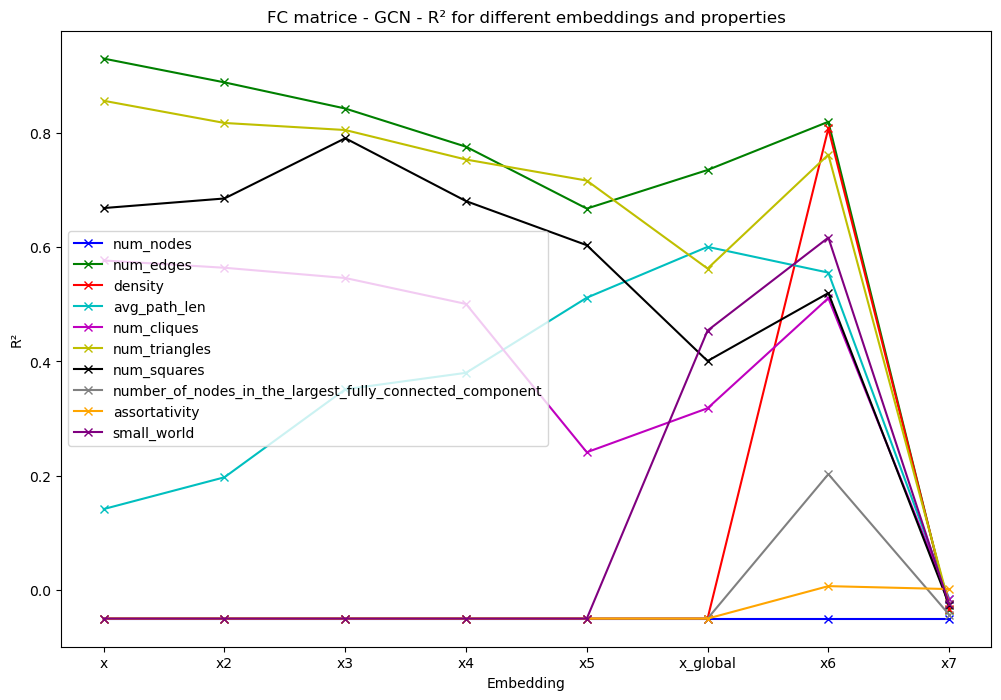

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component','assortativity', 'small_world']
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple']

plt.figure(figsize=(16, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
#put the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save
plt.savefig("results/"+DATASET+"_"+MODEL+"test_R2_full_embedding.png")


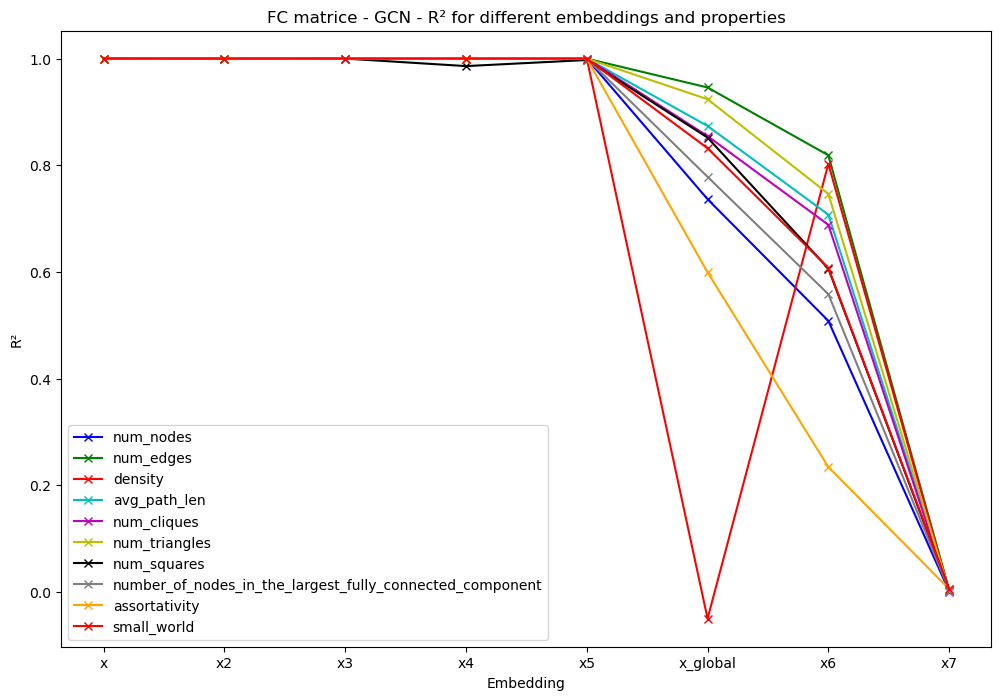

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component','assortativity', 'small_world']
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'red']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_name)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'train_R2_full_embedding.png')


# Test with more properties

In [ ]:
import networkx as nx
import numpy as np

def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Use the average path length of the largest connected component for disconnected graphs
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    
   
def compute_swi(graph):
    # Calculate clustering coefficient and average path length for the given graph
    clustering_coeff = nx.average_clustering(graph)
    avg_path_len = calculate_avg_path_length(graph)
    
    # Generate a random graph with the same number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    random_graph = nx.gnm_random_graph(num_nodes, num_edges)
    
    # Generate a lattice graph with the same number of nodes and edges
    lattice_graph = nx.watts_strogatz_graph(num_nodes, k=4, p=0)  # Adjust k as needed
    
    # Calculate clustering coefficient and average path length for the random graph
    random_clustering_coeff = nx.average_clustering(random_graph)
    random_avg_path_len = calculate_avg_path_length(random_graph)
    
    # Calculate clustering coefficient and average path length for the lattice graph
    lattice_clustering_coeff = nx.average_clustering(lattice_graph)
    lattice_avg_path_len = calculate_avg_path_length(lattice_graph)
    
    # Compute the Small-World Index (SWI)
    swi = ((avg_path_len - lattice_avg_path_len) / (random_avg_path_len - lattice_avg_path_len)) * \
          ((clustering_coeff - random_clustering_coeff) / (lattice_clustering_coeff - random_clustering_coeff))
    
    return swi


def betweenness_centralization(G):
    n = len(G)
    betweenness = nx.betweenness_centrality(G)
    max_betweenness = max(betweenness.values())
    centralization = sum(max_betweenness - bet for bet in betweenness.values())
    if n > 2:
        centralization /= (n - 1) * (n - 2) / 2
    return centralization

def pagerank_centralization(G, alpha=0.85):
    n = len(G)
    pagerank = nx.pagerank(G, alpha=alpha)
    max_pagerank = max(pagerank.values())
    centralization = sum(max_pagerank - pr for pr in pagerank.values())
    if n > 1:
        centralization /= (n - 1)
    return centralization

def clustering_properties(G):
    average_clustering = nx.average_clustering(G)
    transitivity = nx.transitivity(G)
    return average_clustering, transitivity

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        
        # Number of nodes
        num_nodes = G.number_of_nodes()
        
        # Number of edges
        num_edges = G.number_of_edges()
        
        # Density
        density = nx.density(G)
        
        # Average Path Length
        avg_path_len = calculate_avg_path_length(G)
        
        # Diameter
        if nx.is_connected(G):
            diameter = nx.diameter(G)
        else:
            # Use the diameter of the largest connected component for disconnected graphs
            components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
            largest_component = max(components, key=len)
            diameter = nx.diameter(largest_component)
        
        # Radius
        if nx.is_connected(G):
            radius = nx.radius(G)
        else:
            radius = nx.radius(largest_component)
        
        # Clustering Coefficient
        clustering_coeff = nx.average_clustering(G)
        
        # Transitivity
        transitivity = nx.transitivity(G)
        
        # Assortativity
        assortativity = nx.degree_assortativity_coefficient(G)
        
        # Number of Cliques
        num_cliques = len(list(nx.find_cliques(G)))
        
        # Number of Triangles
        num_triangles = sum(nx.triangles(G).values()) / 3
        
        # Number of Squares (4-cycles)
        num_squares = sum(nx.square_clustering(G).values()) / 4
        
        # Size of the Largest Connected Component
        largest_component_size = len(max(nx.connected_components(G), key=len))
        
        # Average Degree
        degrees = [d for n, d in G.degree()]
        avg_degree = np.mean(degrees)
        
        # Betweenness Centrality
        betweenness_centrality = nx.betweenness_centrality(G)
        avg_betweenness_centrality = np.mean(list(betweenness_centrality.values()))
        
        # Eigenvalues of the Adjacency Matrix (for spectral properties)
        eigenvalues = np.linalg.eigvals(nx.adjacency_matrix(G).todense())
        spectral_radius = max(eigenvalues)
        algebraic_connectivity = sorted(eigenvalues)[1]  # second smallest eigenvalue
        
        # Graph Laplacian Eigenvalues
        laplacian_eigenvalues = np.linalg.eigvals(nx.laplacian_matrix(G).todense())
        graph_energy = sum(abs(laplacian_eigenvalues))
        
        # Small-World-ness
        # Compare clustering coefficient and average path length with those of a random graph
        random_graph = nx.gnm_random_graph(num_nodes, num_edges)
        random_clustering_coeff = nx.average_clustering(random_graph)
        random_avg_path_len = calculate_avg_path_length(random_graph)
        small_world_coefficient = (clustering_coeff / random_clustering_coeff) / (avg_path_len / random_avg_path_len)

        small_world_index = compute_swi(G)

        # Calculate Betweenness Centralization
        betweenness_cent = betweenness_centralization(G)
        print(f"Betweenness Centralization: {betweenness_cent}")

        # Calculate PageRank Centralization
        pagerank_cent = pagerank_centralization(G)
        print(f"PageRank Centralization: {pagerank_cent}")

        # Calculate Clustering properties
        avg_clustering, transitivity = clustering_properties(G)
        print(f"Average Clustering Coefficient: {avg_clustering}")
        print(f"Transitivity: {transitivity}")
        
        properties.append((
            num_nodes,
            num_edges,
            density,
            avg_path_len,
            diameter,
            radius,
            clustering_coeff,
            transitivity,
            assortativity,
            num_cliques,
            num_triangles,
            num_squares,
            largest_component_size,
            avg_degree,
            avg_betweenness_centrality,
            spectral_radius,
            algebraic_connectivity,
            graph_energy,
            small_world_coefficient, 
            betweenness_cent,
            pagerank_cent,
            avg_clustering,
            small_world_index           

        ))
    return properties






In [ ]:
train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)

In [14]:
#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "rb") as f:
    train_properties_long = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "rb") as f:
    test_properties_long = pkl.load(f)

In [ ]:
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    # Flatten the embeddings before determining the input size
    train_embedding_flat = train_embedding.view(train_embedding.size(0), -1)
    test_embedding_flat = test_embedding.view(test_embedding.size(0), -1)
    #print the shapes
    print(train_embedding_flat.shape)
    print(test_embedding_flat.shape)
    input_size = train_embedding_flat.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 2000000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding_flat).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding_flat).squeeze().cpu().numpy()
            test_pred = model(test_embedding_flat).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1


#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long_full_embedding.pkl", "wb") as f:
    pkl.dump(results, f)

/scratch-local/tpelletreaudur.7651293/ipykernel_3712713/225588825.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
/scratch-local/tpelletreaudur.7651293/ipykernel_3712713/225588825.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)


torch.Size([1044, 59392])
torch.Size([55, 59392])
Epoch [1000/2000000], Property: num_nodes, Loss: 0.0001
Epoch [2000/2000000], Property: num_nodes, Loss: 0.0000
Epoch [3000/2000000], Property: num_nodes, Loss: 0.0000
Epoch [4000/2000000], Property: num_nodes, Loss: 0.0000
Early stopping at epoch 4735
Embedding: torch.Size([1044, 116, 512])
Property: num_nodes
  Train MSE: 0.0000, Test MSE: 14.8778
  Train R²: 1.0000, Test R²: -15.8939
Epoch [1000/2000000], Property: num_edges, Loss: 95.6582
Epoch [2000/2000000], Property: num_edges, Loss: 3.1035
Epoch [3000/2000000], Property: num_edges, Loss: 0.0337
Epoch [4000/2000000], Property: num_edges, Loss: 0.0007
Epoch [5000/2000000], Property: num_edges, Loss: 0.0000
Epoch [6000/2000000], Property: num_edges, Loss: 0.0000
Epoch [7000/2000000], Property: num_edges, Loss: 0.0000
Epoch [8000/2000000], Property: num_edges, Loss: 0.0000
Early stopping at epoch 8580
Embedding: torch.Size([1044, 116, 512])
Property: num_edges
  Train MSE: 0.0000, T

Epoch [8000/2000000], Property: graph_energy, Loss: 0.0000
Epoch [9000/2000000], Property: graph_energy, Loss: 0.0000
Epoch [10000/2000000], Property: graph_energy, Loss: 0.0000
Early stopping at epoch 10779
Embedding: torch.Size([1044, 116, 512])
Property: graph_energy
  Train MSE: 0.0000, Test MSE: 5071.9897
  Train R²: 1.0000, Test R²: 0.9293
Epoch [1000/2000000], Property: small_world_coefficient, Loss: 0.0004
Epoch [2000/2000000], Property: small_world_coefficient, Loss: 0.0004
Epoch [3000/2000000], Property: small_world_coefficient, Loss: 0.0004
Epoch [4000/2000000], Property: small_world_coefficient, Loss: 0.0004
Early stopping at epoch 4001
Embedding: torch.Size([1044, 116, 512])
Property: small_world_coefficient
  Train MSE: 0.0004, Test MSE: 0.8690
  Train R²: 0.9997, Test R²: -0.0646
Epoch [1000/2000000], Property: betweenness_cent, Loss: 0.0000
Epoch [2000/2000000], Property: betweenness_cent, Loss: 0.0000
Epoch [3000/2000000], Property: betweenness_cent, Loss: 0.0000
Epoch

In [17]:
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long_full_embedding.pkl", "rb") as f:
    results = pkl.load(f)

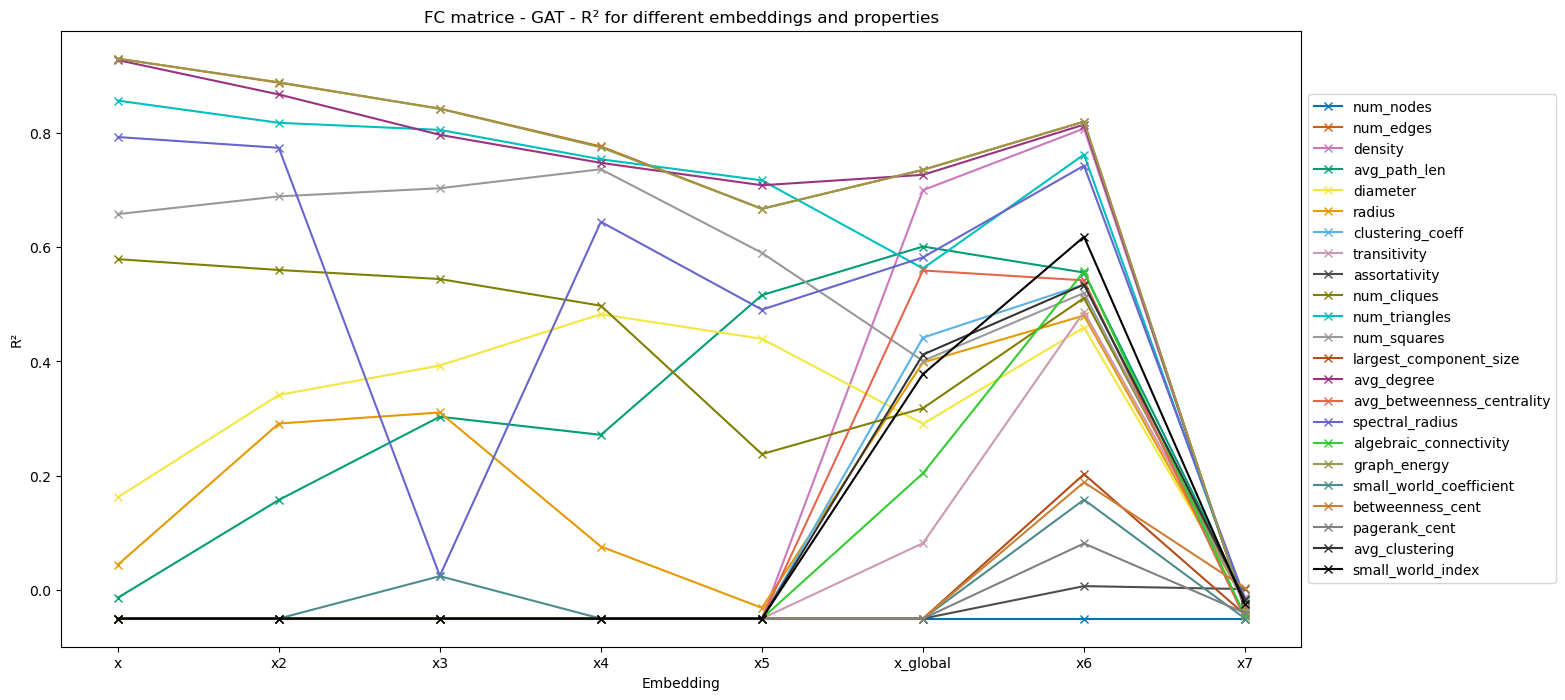

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55),    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2),      # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]

property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']

plt.figure(figsize=(16, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
#put the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('FC matrice - GAT - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig("results/"+DATASET+"_"+MODEL+"_test_R2_plot_long_full_embedding.png", dpi=300, bbox_inches='tight')

In [25]:
#print the R2 values in order (bigger to smaller) for x_global

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']

embeddings_names = ['x', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

#sort the R2 values for x_global
r2_values = []
for property_name in property_names_long:
    r2_values.append(results[('x_global', property_name)][3])

r2_values_sorted = sorted(r2_values, reverse=True)
print(r2_values_sorted)

#sort the property names
property_names_long_sorted = [x for _, x in sorted(zip(r2_values, property_names_long), reverse=True)]
print(property_names_long_sorted)

[0.7350330352783203, 0.7350292205810547, 0.7263637185096741, 0.6995654106140137, 0.6009362936019897, 0.5819159746170044, 0.5625823736190796, 0.5590296387672424, 0.44154244661331177, 0.41189390420913696, 0.4008307456970215, 0.3981105089187622, 0.3777710795402527, 0.31806808710098267, 0.2906675338745117, 0.20418882369995117, 0.08195102214813232, -0.4532257318496704, -0.4605642557144165, -0.7919222116470337, -0.8592501878738403, -0.9522322416305542, -3.423175811767578]
['num_edges', 'graph_energy', 'avg_degree', 'density', 'avg_path_len', 'spectral_radius', 'num_triangles', 'avg_betweenness_centrality', 'clustering_coeff', 'avg_clustering', 'num_squares', 'radius', 'small_world_index', 'num_cliques', 'diameter', 'algebraic_connectivity', 'transitivity', 'small_world_coefficient', 'num_nodes', 'largest_component_size', 'pagerank_cent', 'assortativity', 'betweenness_cent']


In [26]:
#same for x6

#sort the R2 values for x6
r2_values = []
for property_name in property_names_long:
    r2_values.append(results[('x6', property_name)][3])

r2_values_sorted = sorted(r2_values, reverse=True)
print(r2_values_sorted)

#sort the property names
property_names_long_sorted = [x for _, x in sorted(zip(r2_values, property_names_long), reverse=True)]
print(property_names_long_sorted)

[0.8194268941879272, 0.8194267749786377, 0.8142404556274414, 0.8073222637176514, 0.7618439197540283, 0.7423429489135742, 0.6179719567298889, 0.55736243724823, 0.5554108023643494, 0.5417340993881226, 0.5344437956809998, 0.5344277620315552, 0.5196582078933716, 0.5108824968338013, 0.48675990104675293, 0.48016202449798584, 0.45910871028900146, 0.20270949602127075, 0.18851035833358765, 0.15803420543670654, 0.08141297101974487, 0.006791055202484131, -0.25567591190338135]
['graph_energy', 'num_edges', 'avg_degree', 'density', 'num_triangles', 'spectral_radius', 'small_world_index', 'algebraic_connectivity', 'avg_path_len', 'avg_betweenness_centrality', 'avg_clustering', 'clustering_coeff', 'num_squares', 'num_cliques', 'transitivity', 'radius', 'diameter', 'largest_component_size', 'betweenness_cent', 'small_world_coefficient', 'pagerank_cent', 'assortativity', 'num_nodes']


In [27]:
#same for x7

#sort the R2 values for x7
r2_values = []
for property_name in property_names_long:
    r2_values.append(results[('x7', property_name)][3])

r2_values_sorted = sorted(r2_values, reverse=True)
print(r2_values_sorted)

#sort the property names
property_names_long_sorted = [x for _, x in sorted(zip(r2_values, property_names_long), reverse=True)]
print(property_names_long_sorted)

[0.003363192081451416, 0.001625657081604004, -0.012186527252197266, -0.014872908592224121, -0.01561582088470459, -0.0165787935256958, -0.01682889461517334, -0.016849756240844727, -0.019893407821655273, -0.021462678909301758, -0.024623751640319824, -0.025351524353027344, -0.025546908378601074, -0.03253281116485596, -0.0334775447845459, -0.03432416915893555, -0.03432416915893555, -0.04036545753479004, -0.04309415817260742, -0.04545176029205322, -0.06608438491821289, -0.07362997531890869, -0.40564024448394775]
['betweenness_cent', 'assortativity', 'transitivity', 'spectral_radius', 'avg_path_len', 'num_cliques', 'clustering_coeff', 'avg_clustering', 'diameter', 'radius', 'num_triangles', 'small_world_index', 'num_squares', 'density', 'avg_degree', 'num_edges', 'graph_energy', 'pagerank_cent', 'largest_component_size', 'algebraic_connectivity', 'num_nodes', 'small_world_coefficient', 'avg_betweenness_centrality']


In [29]:
#print all the R2 values for all the layers 
# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']

embeddings_names = ['x', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

for name_of_embedding in embeddings_names:
    print(f"Embedding: {name_of_embedding}")
    for property_name in property_names_long:
        print(f"  {property_name}: {results[(name_of_embedding, property_name)][3]:.4f}")

#present the results as a table with the properties in column and the embeddings in rows

import pandas as pd

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']

embeddings_names = ['x', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

# Create a dictionary to store the R² values
r2_values = {name: [] for name in embeddings_names}
for name_of_embedding in embeddings_names:
    for property_name in property_names_long:
        r2_values[name_of_embedding].append(results[(name_of_embedding, property_name)][3])

# Create a DataFrame from the dictionary
df = pd.DataFrame(r2_values, index=property_names_long)
df

Embedding: x
  num_nodes: -15.4524
  num_edges: 0.9297
  density: -219.9830
  avg_path_len: -0.0136
  diameter: 0.1622
  radius: 0.0441
  clustering_coeff: -42.2134
  transitivity: -30.5825
  assortativity: -6.6625
  num_cliques: 0.5788
  num_triangles: 0.8562
  num_squares: 0.6576
  largest_component_size: -5.0297
  avg_degree: 0.9271
  avg_betweenness_centrality: -4719.4741
  spectral_radius: 0.7925
  algebraic_connectivity: -0.0640
  graph_energy: 0.9294
  small_world_coefficient: -0.3033
  betweenness_cent: -103527.2734
  pagerank_cent: -48914.4922
  avg_clustering: -25.2548
  small_world_index: -5.9210
Embedding: x2
  num_nodes: -23.7591
  num_edges: 0.8877
  density: -194.2293
  avg_path_len: 0.1575
  diameter: 0.3412
  radius: 0.2913
  clustering_coeff: -38.3133
  transitivity: -48.3468
  assortativity: -14.4493
  num_cliques: 0.5599
  num_triangles: 0.8174
  num_squares: 0.6886
  largest_component_size: -7.7638
  avg_degree: 0.8670
  avg_betweenness_centrality: -6472.5483
  spe

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,x,x2,x3,x4,x5,x_global,x6,x7
num_nodes,-15.452393,-23.759108,-39.544643,-67.619965,-101.961174,-0.460564,-0.255676,-0.066084
num_edges,0.929738,0.887677,0.842211,0.775976,0.666924,0.735033,0.819427,-0.034324
density,-219.983017,-194.229294,-373.429138,-216.826050,-181.789398,0.699565,0.807322,-0.032533
avg_path_len,-0.013609,0.157519,0.303142,0.271415,0.515856,0.600936,0.555411,-0.015616
diameter,0.162154,0.341225,0.392703,0.482525,0.439480,0.290668,0.459109,-0.019893
radius,0.044063,0.291256,0.310566,0.076059,-0.031275,0.398111,0.480162,-0.021463
clustering_coeff,-42.213398,-38.313347,-27.266817,-26.980474,-28.914547,0.441542,0.534428,-0.016829
transitivity,-30.582478,-48.346783,-36.094578,-25.299391,-29.659584,0.081951,0.486760,-0.012187
assortativity,-6.662499,-14.449257,-8.281601,-6.109235,-6.045974,-0.952232,0.006791,0.001626
num_cliques,0.578799,0.559899,0.544044,0.497410,0.237689,0.318068,0.510882,-0.016579


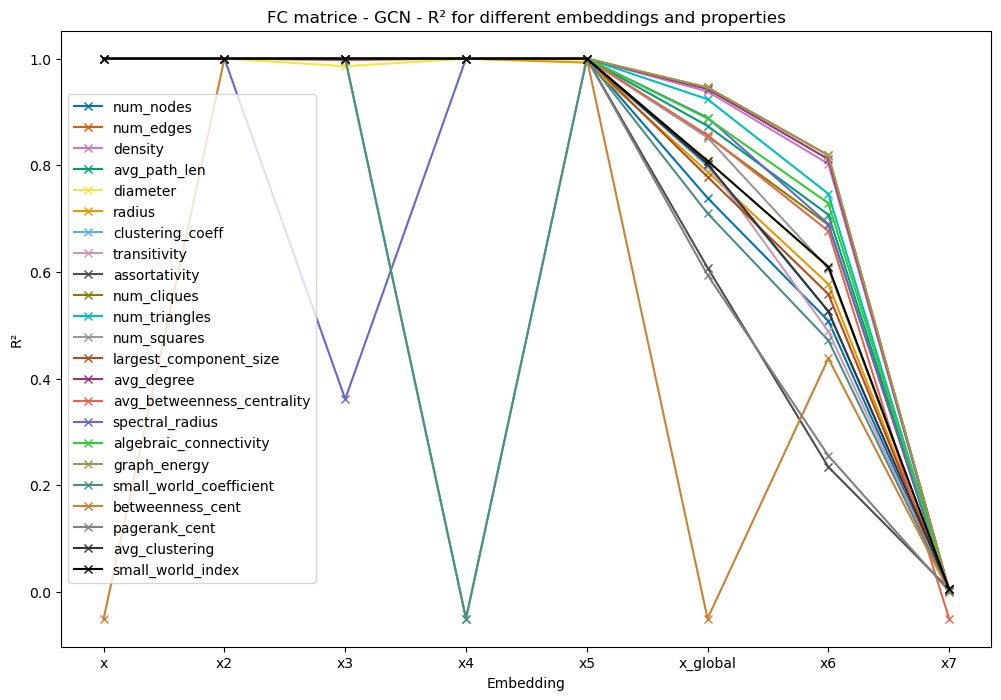

<Figure size 640x480 with 0 Axes>

In [27]:
plt.figure(figsize=(12, 8))
import matplotlib.pyplot as plt
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55),    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2),      # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]

property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_names_long)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)

    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig("results/"+DATASET+"_"+MODEL+"_train_R2_plot_long_full_embedding.png", dpi=300, bbox_inches='tight')

# comparison with a gnn train on random (the y are shuffled)

In [28]:
### comparison with a gnn train on random (the y are shuffled)
from Datasets.FC.create_dataset import read_dataset
dataset = read_dataset()
MODEL = "GAT"
DATASET = "FC_suffled"


from models.models_FC import GAT_framework as framework # import the model

In [29]:
#shuffle the y values of the dataset
import numpy as np
import torch

# y = np.array([data.y for data in dataset])
# y = np.array(y, dtype=np.int64)  # Ensure y is a numeric array of type int64

# np.random.shuffle(y)

# #make y torch.int64, tensor([0]) instead of [0]
# y = torch.tensor(y, dtype=torch.int64)

# for i in range(len(dataset)):
#     dataset[i].y = y[i]

In [30]:
#save the dataset
import pickle as pkl

# with open("Datasets/FC/"+DATASET+"_"+MODEL+".pkl", "wb") as f:
#     pkl.dump(dataset, f)

#load the dataset
with open("Datasets/FC/"+DATASET+"_"+MODEL+".pkl", "rb") as f:
    dataset = pkl.load(f)

In [31]:
gnn = framework(dataset)

c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# gnn.iterate()

In [32]:
#save the model 
# gnn.save_model(path="models/"+DATASET+"_"+MODEL+".pt")
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+".pt", map_location='cpu')
gnn.evaluate()

Test Loss: 0.811, Train Acc: 0.999 Test Acc: 0.436


In [34]:
train_features, test_features = gnn.evaluate_with_features2()

In [ ]:
train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)
import pickle as pkl

In [35]:
#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [ ]:


"""
The embeddings of GAT are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

# train_y = torch.tensor(train_properties, dtype=torch.float32)
# test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']


property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    # Flatten the embeddings before determining the input size
    train_embedding_flat = train_embedding.view(train_embedding.size(0), -1)
    test_embedding_flat = test_embedding.view(test_embedding.size(0), -1)
    #print the shapes
    print(train_embedding_flat.shape)
    print(test_embedding_flat.shape)
    input_size = train_embedding_flat.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 2000000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding_flat).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding_flat).squeeze().cpu().numpy()
            test_pred = model(test_embedding_flat).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long_full_embedding.pkl", "wb") as f:
    pkl.dump(results, f)

In [36]:
#load results 
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long_full_embedding.pkl", "rb") as f:
    results = pkl.load(f)

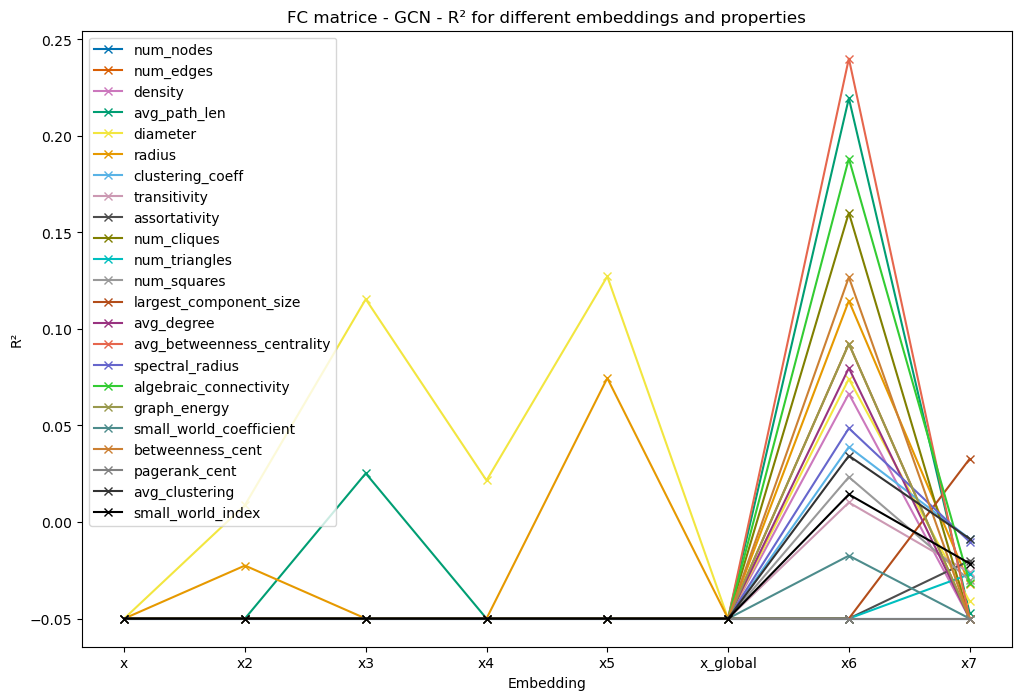

<Figure size 640x480 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55),    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2),      # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]

property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'test_R2_plot_long_full_embedding.png')

# Node embedding probing

/!\ Try to not forget that we need to change the batch_size to 1 if we want to probe for node properties as we need the forward pass to be made 1 graph by 1 graph at a time. 

In [38]:
from Datasets.FC.create_dataset import read_dataset
dataset = read_dataset()
import torch
torch.manual_seed(37)
MODEL = "GAT"
DATASET = "FC"
from models.models_FC import GAT_framework as framework # import the model
gnn = framework(dataset)
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server.pt")
gnn.evaluate()

c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Test Loss: 0.819, Train Acc: 1.000 Test Acc: 0.600


In [ ]:
import networkx as nx
# Define function to compute node-level properties
def compute_node_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        node_degrees = list(dict(G.degree()).values())
        clustering_coeffs = list(nx.clustering(G).values())
        betweenness_centralities = list(nx.betweenness_centrality(G).values())
        eigenvector_centralities = list(nx.eigenvector_centrality(G, max_iter=10000).values())
        Local_clustering_coefficients = list(nx.clustering(G).values())

        properties.append((node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, Local_clustering_coefficients))
    return properties

# Compute node-level properties for train and test sets
# Ensure gnn.train_idx and gnn.test_idx are lists of integers
train_idx = gnn.train_idx.tolist() if isinstance(gnn.train_idx, torch.Tensor) else gnn.train_idx
test_idx = gnn.test_idx.tolist() if isinstance(gnn.test_idx, torch.Tensor) else gnn.test_idx

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties([gnn.dataset[i] for i in train_idx])
test_node_properties = compute_node_properties([gnn.dataset[i] for i in test_idx])

#train_node_properties is a list of tuples, where each tuple contains 5 lists, each list contains the node-level property for each node in the graph

In [ ]:
len(train_node_properties), len(test_node_properties)

In [ ]:
# Check the length of the first three betweenness centralities of the three first graphs in the train set
[len(train_node_properties[i][2]) for i in range(3)]

We see that for each graph, the length of the betweenness centralities, and in general the length of properties, are equal to the number of nodes in the graph and thus
is equal to the length of the x matrix in the features. 

## Node embeddings

In [39]:
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=True)

len of features:  5
features[0].shape:  torch.Size([116, 512])
features[1].shape:  torch.Size([116, 512])
features[2].shape:  torch.Size([116, 512])
features[3].shape:  torch.Size([116, 512])
train_features[0][0].shape:  (116, 512)
len of features:  5
features[0].shape:  torch.Size([116, 512])
features[1].shape:  torch.Size([116, 512])
features[2].shape:  torch.Size([116, 512])
features[3].shape:  torch.Size([116, 512])
train_features[0][0].shape:  (116, 512)
len of features:  5
features[0].shape:  torch.Size([116, 512])
features[1].shape:  torch.Size([116, 512])
features[2].shape:  torch.Size([116, 512])
features[3].shape:  torch.Size([116, 512])
train_features[0][0].shape:  (116, 512)
len of features:  5
features[0].shape:  torch.Size([116, 512])
features[1].shape:  torch.Size([116, 512])
features[2].shape:  torch.Size([116, 512])
features[3].shape:  torch.Size([116, 512])
train_features[0][0].shape:  (116, 512)
len of features:  5
features[0].shape:  torch.Size([116, 512])
features[

In [ ]:
len(train_features), len(test_features)

In [ ]:
# Check the shape of the first graph's features
first_graph_features = train_features[1]
for i, feature in enumerate(first_graph_features):
    print(f"Feature {i+1} shape:", feature.shape)

In [ ]:
train_features[1][0][26]

## Embedding probing

##### Probing for the top n nodes on train_features only and averaging the results of the different diagnostif classifiers

In [40]:
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Function to get the top 3 nodes based on a specific property
def get_top_nodes(property_list, top_n=37):
    sorted_indices = sorted(range(len(property_list)), key=lambda k: property_list[k], reverse=True)
    return sorted_indices[:top_n]

In [ ]:

# Get the top 30 nodes for local clustering coefficient and eigenvector centrality
top_nodes_degrees = [get_top_nodes(graph_props[0], 37) for graph_props in train_node_properties]  # Assuming 0th index is for node degrees
top_nodes_clustering = [get_top_nodes(graph_props[1], 37) for graph_props in train_node_properties]  # Assuming 1st index is for clustering coefficient
top_nodes_betweenness = [get_top_nodes(graph_props[2], 37) for graph_props in train_node_properties]  # Assuming 2nd index is for betweenness centrality
top_nodes_local_clustering = [get_top_nodes(graph_props[3], 37) for graph_props in train_node_properties]  # Assuming 3rd index is for local clustering coefficient
top_nodes_eigenvector = [get_top_nodes(graph_props[4], 37) for graph_props in train_node_properties]  # Assuming 4th index is for eigenvector centrality

In [ ]:
# Prepare the data for linear regression model training
def prepare_regression_data(features, properties, top_nodes_indices):
    X = []
    y = []
    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices[i]:
                X.append(graph_features[layer][node_index])
                y.append(properties[i][node_index])
    return torch.tensor(X), torch.tensor(y)

# Training and evaluating linear regression models
def train_and_evaluate_regression(X, y):
    model = LinearModel(X.shape[1], 1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    model.train()
    for epoch in range(1000):
        optimizer.zero_grad()
        outputs = model(X.float())
        loss = criterion(outputs, y.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X.float()).view(-1)
        r2 = r2_score(y.float(), predictions)
    return r2

In [ ]:
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data for node degree regression
X_node_degree, y_node_degree = prepare_regression_data(train_features, [props[0] for props in train_node_properties], top_nodes_degrees)

# Train and evaluate model for node degree
r2_node_degree = train_and_evaluate_regression(X_node_degree, y_node_degree)
print(f'R² for node degree prediction: {r2_node_degree}')

# Prepare data for betweenness centrality regression
X_betweenness, y_betweenness = prepare_regression_data(train_features, [props[2] for props in train_node_properties], top_nodes_betweenness)

# Train and evaluate model for betweenness centrality
r2_betweenness = train_and_evaluate_regression(X_betweenness, y_betweenness)
print(f'R² for betweenness centrality prediction: {r2_betweenness}')

# Prepare data for local clustering coefficient regression
X_local_clustering, y_local_clustering = prepare_regression_data(train_features, [props[3] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for local clustering coefficient
r2_local_clustering = train_and_evaluate_regression(X_local_clustering, y_local_clustering)
print(f'R² for local clustering coefficient prediction: {r2_local_clustering}')

# Prepare data for eigenvector centrality regression
X_eigenvector, y_eigenvector = prepare_regression_data(train_features, [props[4] for props in train_node_properties], top_nodes_eigenvector)

# Train and evaluate model for eigenvector centrality
r2_eigenvector = train_and_evaluate_regression(X_eigenvector, y_eigenvector)
print(f'R² for eigenvector centrality prediction: {r2_eigenvector}')

##### Probing for the top n nodes with diagnostic classifier trained on the train set and test on the test set

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Define Linear Model for probing (diagnostic classifier)
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Prepare the data for probing classifier
def prepare_regression_data(features, properties, property_index, top_n_nodes=37):
    X_layers = [[] for _ in range(len(features[0]))]
    y_layers = [[] for _ in range(len(features[0]))]

    for i, graph_features in enumerate(features):
        top_nodes_indices = get_top_nodes(properties[i][property_index], top_n=top_n_nodes)
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices:
                X_layers[layer].append(graph_features[layer][node_index])
                y_layers[layer].append(properties[i][property_index][node_index])

    X_layers = [torch.tensor(X) for X in X_layers]
    y_layers = [torch.tensor(y) for y in y_layers]
    
    return X_layers, y_layers

# Train and evaluate the probing classifier for each layer
def train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers):
    r2_scores_train = []
    r2_scores_test = []
    
    for layer in range(len(X_train_layers)):
        X_train = X_train_layers[layer]
        y_train = y_train_layers[layer]
        X_test = X_test_layers[layer]
        y_test = y_test_layers[layer]
        
        model = LinearModel(X_train.shape[1], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Train the model
        model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            outputs = model(X_train.float())
            loss = criterion(outputs, y_train.float().view(-1, 1))
            loss.backward()
            optimizer.step()
            if epoch % 100 == 0:
                print(f'Layer {layer+1}, Epoch {epoch}, Loss: {loss.item()}')
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions_train = model(X_train.float()).view(-1)
            predictions_test = model(X_test.float()).view(-1)
            r2_train = r2_score(y_train.float(), predictions_train)
            r2_test = r2_score(y_test.float(), predictions_test)
        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)
    
    return r2_scores_train, r2_scores_test

# Aggregate R² scores across all graphs
def aggregate_r2_scores(features_train, properties_train, features_test, properties_test, property_index):
    X_train_layers, y_train_layers = prepare_regression_data(features_train, properties_train, property_index)
    X_test_layers, y_test_layers = prepare_regression_data(features_test, properties_test, property_index)

    #save the results in a file
    with open("results/"+DATASET+"_"+MODEL+"_X_train_layers.pkl", "wb") as f:
        pkl.dump(X_train_layers, f)

    with open("results/"+DATASET+"_"+MODEL+"_y_train_layers.pkl", "wb") as f:
        pkl.dump(y_train_layers, f)
    
    r2_scores_train, r2_scores_test = train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers)
    
    return r2_scores_train, r2_scores_test

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients
properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store average R² scores across all layers
avg_r2_train_dict = {name: [] for name in property_names}
avg_r2_test_dict = {name: [] for name in property_names}

# Train and evaluate the probing classifier for each property
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property: {prop_name}")
    avg_r2_train_dict[prop_name], avg_r2_test_dict[prop_name] = aggregate_r2_scores(train_features, train_node_properties, test_features, test_node_properties, prop_idx)

# Plotting the average R² scores across layers for each property
layers = np.arange(len(avg_r2_train_dict[property_names[0]]))


In [11]:

# #save all the variables necessary for the plot
# import pickle as pkl
# with open("results/"+DATASET+"_"+MODEL+"_avg_r2_train_dict_long.pkl", "wb") as f:
#     pkl.dump(avg_r2_train_dict, f)

# with open("results/"+DATASET+"_"+MODEL+"_avg_r2_test_dict_long.pkl", "wb") as f:
#     pkl.dump(avg_r2_test_dict, f)

# with open("results/"+DATASET+"_"+MODEL+"_layers_long.pkl", "wb") as f:
#     pkl.dump(layers, f)

# with open("results/"+DATASET+"_"+MODEL+"_property_names_long.pkl", "wb") as f:
#     pkl.dump(property_names, f)

#load all the variables necessary for the plot
import pickle as pkl
with open("results/"+DATASET+"_"+MODEL+"_avg_r2_train_dict_long.pkl", "rb") as f:
    avg_r2_train_dict = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_avg_r2_test_dict_long.pkl", "rb") as f:
    avg_r2_test_dict = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_layers_long.pkl", "rb") as f:
    layers = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_property_names_long.pkl", "rb") as f:
    property_names = pkl.load(f)

    #load the layer results
with open("results/"+DATASET+"_"+MODEL+"_X_train_layers.pkl", "rb") as f:
    X_train_layers = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_y_train_layers.pkl", "rb") as f:
    y_train_layers = pkl.load(f)

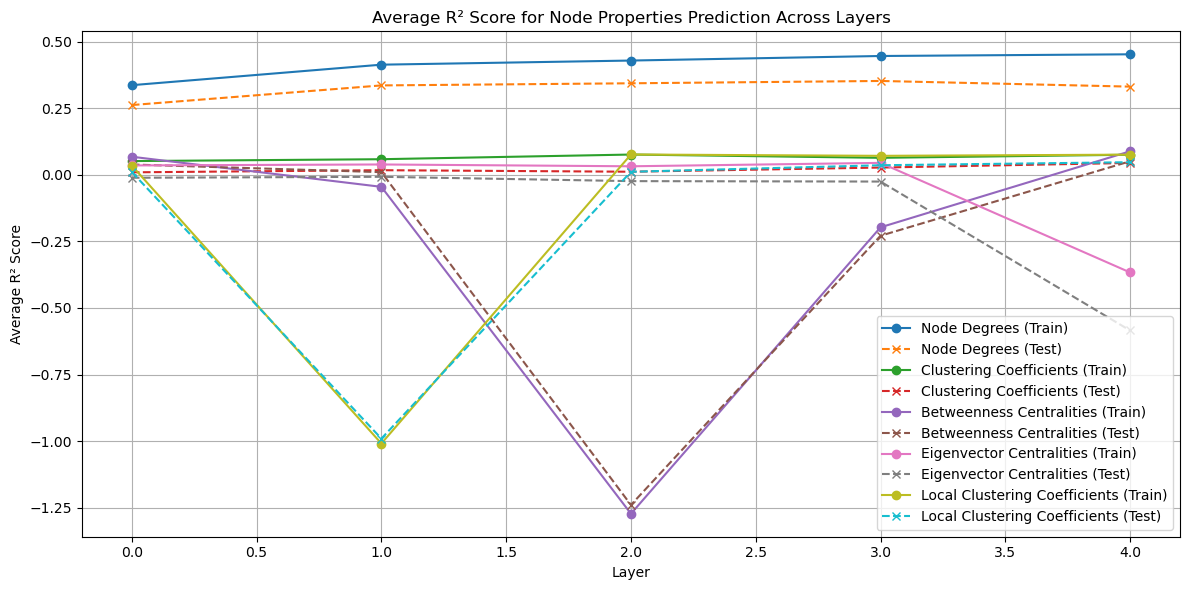

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

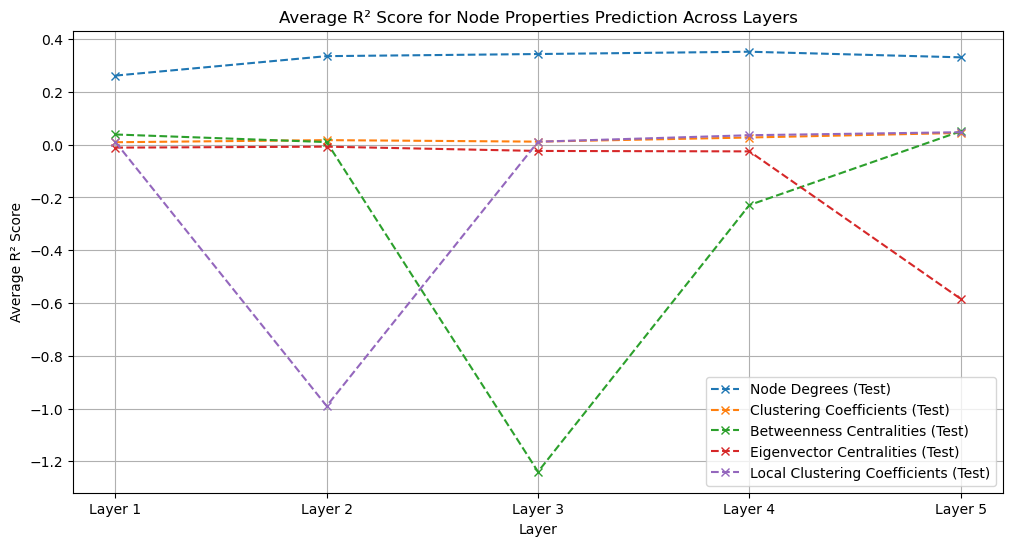

In [13]:
#plot only test results
plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
#x axis called layer 1, layer 2, etc
plt.xticks(range(len(layers)), [f'Layer {i+1}' for i in layers])           
plt.grid(True)

y=1 and y=0 as two different plots

In [ ]:
# Extract labels from the dataset using train_idx_list and test_idx_list
train_idx_list = gnn.train_idx.tolist()
test_idx_list = gnn.test_idx.tolist()

train_labels = [gnn.dataset[i].y.item() for i in train_idx_list]
test_labels = [gnn.dataset[i].y.item() for i in test_idx_list]

# Split the dataset by label y=0 and y=1
def split_by_label(features, properties, labels):
    features_0, properties_0, features_1, properties_1 = [], [], [], []
    
    for i, label in enumerate(labels):
        if label == 0:
            features_0.append(features[i])
            properties_0.append(properties[i])
        else:
            features_1.append(features[i])
            properties_1.append(properties[i])
    
    return features_0, properties_0, features_1, properties_1

# Assuming you have train_features, train_node_properties, test_features, test_node_properties from your GNN
train_features_0, train_node_properties_0, train_features_1, train_node_properties_1 = split_by_label(train_features, train_node_properties, train_labels)
test_features_0, test_node_properties_0, test_features_1, test_node_properties_1 = split_by_label(test_features, test_node_properties, test_labels)

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients
properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store average R² scores across all layers for y=0 and y=1
avg_r2_train_dict_0 = {name: [] for name in property_names}
avg_r2_test_dict_0 = {name: [] for name in property_names}
avg_r2_train_dict_1 = {name: [] for name in property_names}
avg_r2_test_dict_1 = {name: [] for name in property_names}

# Train and evaluate the probing classifier for each property for y=0
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property for y=0: {prop_name}")
    avg_r2_train_dict_0[prop_name], avg_r2_test_dict_0[prop_name] = aggregate_r2_scores(train_features_0, train_node_properties_0, test_features_0, test_node_properties_0, prop_idx)

# Train and evaluate the probing classifier for each property for y=1
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property for y=1: {prop_name}")
    avg_r2_train_dict_1[prop_name], avg_r2_test_dict_1[prop_name] = aggregate_r2_scores(train_features_1, train_node_properties_1, test_features_1, test_node_properties_1, prop_idx)

# Plotting the average R² scores across layers for each property, separately for y=0 and y=1
layers = np.arange(len(avg_r2_train_dict_0[property_names[0]]))

plt.figure(figsize=(12, 12))

# Plot for y=0
plt.subplot(2, 1, 1)
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict_0[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict_0[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers (y=0)')
plt.legend()
plt.grid(True)

# Plot for y=1
plt.subplot(2, 1, 2)
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict_1[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict_1[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers (y=1)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Node embedding probing

/!\ Try to not forget that we need to change the batch_size to 1 if we want to probe for node properties as we need the forward pass to be made 1 graph by 1 graph at a time. 

In [1]:
from Datasets.FC.create_dataset import read_dataset
dataset = read_dataset()
import torch
torch.manual_seed(37)
MODEL = "GAT"
DATASET = "FC"
from models.models_FC import GAT_framework as framework # import the model
gnn = framework(dataset)
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server.pt")
gnn.evaluate()

c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Test Loss: 0.819, Train Acc: 1.000 Test Acc: 0.600


## Node Properties 

In [ ]:
import networkx as nx
import torch

def compute_node_properties(data, indices):
    properties = []
    for idx in indices:
        graph_data = data[idx]
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        
        # Add all nodes to the graph to handle disconnected nodes
        all_nodes = set(range(len(graph_data.x)))
        connected_nodes = set(G.nodes())
        disconnected_nodes = all_nodes - connected_nodes
        
        # Calculate node properties using NetworkX for connected nodes
        degree = dict(G.degree())
        clustering = nx.clustering(G)
        betweenness = nx.betweenness_centrality(G)
        closeness = nx.closeness_centrality(G)
        eigenvector = nx.eigenvector_centrality(G, max_iter=10000)
        pagerank = nx.pagerank(G)

        # Initialize properties with zeros for all nodes
        node_properties = [{'degree': 0, 'clustering': 0, 'betweenness': 0, 'closeness': 0, 'eigenvector': 0, 'pagerank': 0} for _ in all_nodes]
        
        # Store properties for each connected node in the graph
        for node in connected_nodes:
            node_properties[node] = {
                'degree': degree[node],
                'clustering': clustering[node],
                'betweenness': betweenness[node],
                'closeness': closeness[node],
                'eigenvector': eigenvector[node],
                'pagerank': pagerank[node]
            }

        #if there a disconnected nodes : print 
        # if disconnected_nodes:
        #     print(f"Graph {idx}: Disconnected nodes: {disconnected_nodes}")
        #     print(node_properties)

        properties.append(node_properties)
    return properties

# Ensure gnn.train_idx and gnn.test_idx are lists of integers
train_idx = gnn.train_idx.tolist() if isinstance(gnn.train_idx, torch.Tensor) else gnn.train_idx
test_idx = gnn.test_idx.tolist() if isinstance(gnn.test_idx, torch.Tensor) else gnn.test_idx

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties(gnn.dataset, train_idx)
test_node_properties = compute_node_properties(gnn.dataset, test_idx)


## Features

In [ ]:
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=True)

In [ ]:
len(train_features), len(test_features)

In [ ]:
# Check the shape of the first graph's features
first_graph_features = train_features[1]
for i, feature in enumerate(first_graph_features):
    print(f"Feature {i+1} shape:", feature.shape)

In [ ]:
train_features[1][0][115]

In [ ]:
print(len(train_features))
print(len(train_features[0]))
print(train_features[0][0].shape)

In [ ]:
print(len(train_node_properties))
print(len(train_node_properties[0]))
print(train_node_properties[0][0])

## Linear classifier

**Probe**

Example data structure for multiple graphs

train_features: List of graphs, each with multiple layers of features

```plaintext
train_features = [
    [np.array([...]), np.array([...]), ...],  # Graph 1: features for each layer
    [np.array([...]), np.array([...]), ...],  # Graph 2: features for each layer
    ...
]
```
train_node_properties: List of graphs, each with a list of node properties

```plaintext
train_node_properties = [
    [{'degree': ..., 'clustering': ..., ...}, {'degree': ..., ...}, ...],  # Graph 1: properties for each node
    [{'degree': ..., 'clustering': ..., ...}, {'degree': ..., ...}, ...],  # Graph 2: properties for each node
    ...
]
```
test_features and test_node_properties would be similarly structured for the test set

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

class LinearModel(nn.Module):
    def __init__(self, input_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

In [ ]:
def train_probe_for_layer(features, property_values, test_features, test_property_values, num_epochs=10000, learning_rate=0.01):
    # Convert features and property values to PyTorch tensors if they are NumPy arrays
    if isinstance(features, np.ndarray):
        features = torch.tensor(features, dtype=torch.float32)
    if isinstance(property_values, np.ndarray):
        property_values = torch.tensor(property_values, dtype=torch.float32)

    if isinstance(test_features, np.ndarray):
        test_features = torch.tensor(test_features, dtype=torch.float32)
    if isinstance(test_property_values, np.ndarray):
        test_property_values = torch.tensor(test_property_values, dtype=torch.float32)

    print(f"Training on features with shape: {features.shape} for property values shape: {property_values.shape}")

    model = LinearModel(features.shape[1])  # Features should be 2D: (num_nodes, feature_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(features).squeeze()  # Remove single-dimensional entries
        loss = criterion(output, property_values)
        loss.backward()
        optimizer.step()

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        pred = model(test_features).squeeze()
        mse = criterion(pred, test_property_values).item()
        # Flatten the tensors for proper use of r2_score
        r2 = r2_score(test_property_values.cpu().numpy(), pred.cpu().numpy())

    return mse, r2


### Option 2: Train a Single Classifier Across All Graphs

This approach involves combining data from all graphs to train a single probe for each property across the graphs. This assumes that the properties across different graphs share some common structure that can be captured by a single model. We modify the `evaluate_layer_probes` function to aggregate features and properties across all graphs before training.

This approach results in a single probe being trained for each property at each layer, but the probe is trained on data aggregated from all graphs.

In [ ]:
def evaluate_layer_probes_across_graphs(train_features_list, test_features_list, train_properties_list, test_properties_list):
    num_layers = len(train_features_list[0])  # Assuming all graphs have the same number of layers
    results = []

    num_test_graphs = len(test_features_list)  # Number of graphs in the test set

    for layer_idx in range(num_layers):
        combined_train_features = []
        combined_test_features = []
        combined_train_properties = []
        combined_test_properties = []

        # Aggregate features and properties across all graphs
        for graph_idx in range(len(train_features_list)):
            combined_train_features.append(np.vstack(train_features_list[graph_idx][layer_idx]))

            # Use modulo to cycle through the test graphs
            test_idx = graph_idx % num_test_graphs
            combined_test_features.append(np.vstack(test_features_list[test_idx][layer_idx]))

            combined_train_properties.extend(train_properties_list[graph_idx])
            combined_test_properties.extend(test_properties_list[test_idx])

        combined_train_features = np.vstack(combined_train_features)  # Combine features across graphs
        combined_test_features = np.vstack(combined_test_features)

        # Train and evaluate probe for each property across all graphs
        for property_name in combined_train_properties[0].keys():  # Assuming all nodes have the same properties
            train_property_values = np.array([node[property_name] for node in combined_train_properties])
            test_property_values = np.array([node[property_name] for node in combined_test_properties])

            mse, r2 = train_probe_for_layer(combined_train_features, train_property_values, combined_test_features, test_property_values)
            
            results.append({
                'layer': layer_idx,
                'property': property_name,
                'mse': mse,
                'r2': r2
            })

    return results


In [ ]:
results_across_graphs = evaluate_layer_probes_across_graphs(train_features, test_features, train_node_properties, test_node_properties)

#save the results
with open("results/"+DATASET+"_"+MODEL+"_node_results_across_graphs.pkl", "wb") as f:
    pkl.dump(results_across_graphs, f)

In [2]:
import pickle as pkl
import numpy as np
#load the results
with open("results/"+DATASET+"_"+MODEL+"_node_results_across_graphs.pkl", "rb") as f:
    results_across_graphs = pkl.load(f)

### Choosing Between Options:

- If our graphs are very similar in nature and you expect the relationships between node embeddings and their properties to be consistent across all graphs, **Option 2** (Single Classifier Across Graphs) will be the better choice.
  
- If our graphs are diverse, or we expect the relationships to vary significantly between graphs, *Option 1* (Separate Classifiers) might be more appropriate.

We experiment with both approaches and compare the performance to see which one gives us the best results : we decided to keep option 2

### Results:

- *Layers and Properties*: The function iterate over the layers and properties to aggregate and visualize the R² scores.
  
- *Mean R² Calculation*: The mean R² scores are calculated for each layer and property. If any R² value is below `-0.05`, it is set to `-0.05` to prevent extreme values from skewing the visualization.

- *Plotting*:
  - *Option 1 (`plot_results_per_graph`)*: Plots a separate line for each graph, allowing you to see how the R² scores vary across layers and graphs.
  - *Option 2 (`plot_results_across_graphs`)*: Plots a single line for each property, aggregating the results across all graphs. This provides a high-level view of how each property behaves across layers when considering all graphs together.
  
We decided to keep option 2 as it makes more sense. This function is designed to visualize the results from the `evaluate_layer_probes_across_graphs` function. It will plot the R² scores for each property across layers, combining the results from all graphs into single lines.


In [45]:
import pickle as pkl
import matplotlib.pyplot as plt
def plot_results_across_graphs(results):
    layers = sorted(set(result['layer'] for result in results))
    properties = sorted(set(result['property'] for result in results))
    
    plt.figure(figsize=(12, 6))  # Increase the figure size for better readability
    
    for property_name in properties:
        r2_scores = []
        for layer in layers:
            layer_results = [r for r in results if r['layer'] == layer and r['property'] == property_name]
            # Calculate mean R² score for the layer
            mean_r2 = np.mean([r['r2'] for r in layer_results])
            # Set any R² value below -0.05 to -0.05
            if mean_r2 < -0.05:
                mean_r2 = -0.05
            r2_scores.append(mean_r2)
        
        # Plot the R² scores with crosses and lines, one line per property across all graphs
        plt.plot(layers, r2_scores, marker='x', linestyle='-', label=property_name)

    plt.title('R² Scores Across Layers for Different Properties (Aggregated Across Graphs)')
    plt.xticks(layers, [f'Layer {i+1}' for i in layers])  # Set the x-axis labels to layer numbers
    plt.xlabel('Layer')
    plt.ylabel('R² Score')
    plt.legend()
    plt.grid(True)  # Add grid for better visibility of points and lines
    plt.show()

    # Save the plot
    with open("results/"+DATASET+"_"+MODEL+"_node_results_across_graphs.pkl", "wb") as f:
        pkl.dump(results, f)

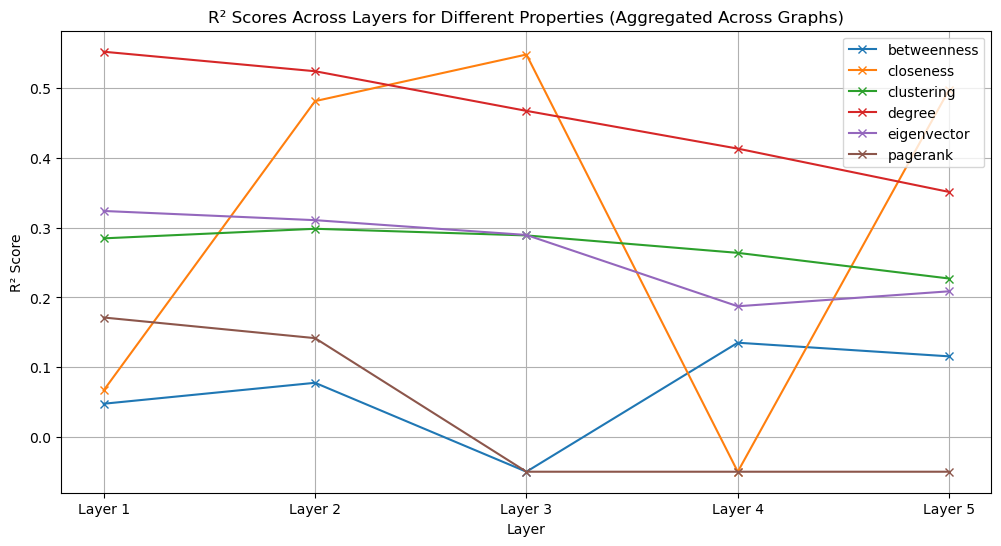

In [46]:
# Plot the results across all graphs
plot_results_across_graphs(results_across_graphs)

In [3]:
# Identify unique layers
layers = set(result['layer'] for result in results_across_graphs)

for layer in layers:
    # Filter results for the current layer
    layer_results = [result for result in results_across_graphs if result['layer'] == layer]
    
    # Extract and sort r2 values along with property names in descending order
    sorted_r2_values = sorted([(result['r2'], result['property']) for result in layer_results], reverse=True, key=lambda x: x[0])
    
    # Print the sorted r2 values with property names for the current layer
    print(f"Layer {layer}:")
    for r2, property in sorted_r2_values:
        print(f"  Property: {property}, R2: {r2}")
    print()  # Add a blank line for better readability

Layer 0:
  Property: degree, R2: 0.5525462627410889
  Property: eigenvector, R2: 0.32408469915390015
  Property: clustering, R2: 0.28479325771331787
  Property: pagerank, R2: 0.17123174667358398
  Property: closeness, R2: 0.06670981645584106
  Property: betweenness, R2: 0.04752516746520996

Layer 1:
  Property: degree, R2: 0.5245674848556519
  Property: closeness, R2: 0.481672465801239
  Property: eigenvector, R2: 0.3108953833580017
  Property: clustering, R2: 0.2985263466835022
  Property: pagerank, R2: 0.1416509747505188
  Property: betweenness, R2: 0.07756847143173218

Layer 2:
  Property: closeness, R2: 0.5485187768936157
  Property: degree, R2: 0.46770477294921875
  Property: eigenvector, R2: 0.2896571755409241
  Property: clustering, R2: 0.2890077829360962
  Property: pagerank, R2: -0.9232481718063354
  Property: betweenness, R2: -1.6182630062103271

Layer 3:
  Property: degree, R2: 0.41353458166122437
  Property: clustering, R2: 0.263988733291626
  Property: eigenvector, R2: 0.1